# Predicting film gross using multiple linear regression #

### In this notebook: ###

__-Cleaning__<br>

__-Time series analysis of film budgets and film gross__ <br>
__-Visualizing gross vs. genre, gross vs. rating as strip plots__<br>

__-Gross/budget ratio for actors and directors as an efficiency ratio__<br>
__-Found the top 20 companies by number of movies produced and top 20 by gross__<br>
__-Found the top 20 actors and top 20 actors by film gross__<br>

__-Correlation found that the strongest positive relationship with gross were budget and votes__<br>

__-Used statsmodels' ordinary least squares to perform simple linear regression to predict gross using the strong and moderately correlated budget and votes as predictor variables__<br>

__-Normalized the target numerical features and performed multivariable linear regression model using SKLearn's linear model. Budget, gross, votes, score, runtime, and release year were used as predictor variables over 10 splits of KFold cross validation__<br>

__-Attempted to improve the model performance with one-hot encoding of genre and rating to include as features__<br>
__-Visualized predicted vs actual gross__<br>

__-Summarized model performance via mean validation score, R2, Adjusted R2, MSE, MAE, and RMSE across 10 folds__<br>
__-Created residual vs predictor plots__

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats import kendalltau

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
%reload_ext autoreload
%autoreload 2
colors = sns.color_palette(palette='bright')

## Import the dataset

In [3]:
#data - 7668 intial entries

full_df = pd.read_csv('movies.csv',)
full_df

name rating      genre  year  \
0                                        The Shining      R      Drama  1980   
1                                    The Blue Lagoon      R  Adventure  1980   
2     Star Wars: Episode V - The Empire Strikes Back     PG     Action  1980   
3                                          Airplane!     PG     Comedy  1980   
4                                         Caddyshack      R     Comedy  1980   
...                                              ...    ...        ...   ...   
7663                                    More to Life    NaN      Drama  2020   
7664                                     Dream Round    NaN     Comedy  2020   
7665                                   Saving Mbango    NaN      Drama  2020   
7666                                    It's Just Us    NaN      Drama  2020   
7667                                       Tee em el    NaN     Horror  2020   

                              released  score      votes         director  \
0        June 13, 1980 (United States)    8.4   927000.0  Stanley Kubrick   
1         July 2, 1980 (United States)    5.8    65000.0   Randal Kleiser   
2        June 20, 1980 (United States)    8.7  1200000.0   Irvin Kershner   
3         July 2, 1980 (United States)    7.7   221000.0     Jim Abrahams   
4        July 25, 1980 (United States)    7.3   108000.0     Harold Ramis   
...                                ...    ...        ...              ...   
7663  October 23, 2020 (United States)    3.1       18.0    Joseph Ebanks   
7664  February 7, 2020 (United States)    4.7       36.0     Dusty Dukatz   
7665         April 27, 2020 (Cameroon)    5.7       29.0     Nkanya Nkwai   
7666   October 1, 2020 (United States)    NaN        NaN    James Randall   
7667   August 19, 2020 (United States)    5.7        7.0     Pereko Mosia   

                       writer              star         country      budget  \
0                Stephen King    Jack Nicholson  United Kingdom  19000000.0   
1     Henry De Vere Stacpoole    Brooke Shields   United States   4500000.0   
2              Leigh Brackett       Mark Hamill   United States  18000000.0   
3                Jim Abrahams       Robert Hays   United States   3500000.0   
4          Brian Doyle-Murray       Chevy Chase   United States   6000000.0   
...                       ...               ...             ...         ...   
7663            Joseph Ebanks      Shannon Bond   United States      7000.0   
7664              Lisa Huston  Michael Saquella   United States         NaN   
7665             Lynno Lovert      Onyama Laura   United States     58750.0   
7666            James Randall     Christina Roz   United States     15000.0   
7667             Pereko Mosia  Siyabonga Mabaso    South Africa         NaN   

            gross                    company  runtime  
0      46998772.0               Warner Bros.    146.0  
1      58853106.0          Columbia Pictures    104.0  
2     538375067.0                  Lucasfilm    124.0  
3      83453539.0         Paramount Pictures     88.0  
4      39846344.0             Orion Pictures     98.0  
...           ...                        ...      ...  
7663          NaN                        NaN     90.0  
7664          NaN  Cactus Blue Entertainment     90.0  
7665          NaN           Embi Productions      NaN  
7666          NaN                        NaN    120.0  
7667          NaN                PK 65 Films    102.0  

[7668 rows x 15 columns]

## Data cleaning and preparation

In [4]:
full_df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [5]:
#converting to categorical variables
convert = ['rating','genre','director','writer','star','country','company']

for col in full_df[convert]:
    full_df[col] = full_df[col].astype('category')
    
full_df.dtypes

name          object
rating      category
genre       category
year           int64
released      object
score        float64
votes        float64
director    category
writer      category
star        category
country     category
budget       float64
gross        float64
company     category
runtime      float64
dtype: object

In [6]:
#how much data is missing per column (null values)
for col in full_df.columns:
    percent_missing = 100*np.mean(full_df[col].isnull())
    print('{}-{}%'.format(col, percent_missing))

name-0.0%
rating-1.004173187271779%
genre-0.0%
year-0.0%
released-0.02608242044861763%
score-0.03912363067292645%
votes-0.03912363067292645%
director-0.0%
writer-0.03912363067292645%
star-0.013041210224308816%
country-0.03912363067292645%
budget-28.31246739697444%
gross-2.464788732394366%
company-0.2217005738132499%
runtime-0.05216484089723526%


In [7]:
#delete duplicates and an entries with NaN 
df = full_df.drop_duplicates(subset=['name'])
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df

name     rating      genre  \
0                                        The Shining          R      Drama   
1                                    The Blue Lagoon          R  Adventure   
2     Star Wars: Episode V - The Empire Strikes Back         PG     Action   
3                                          Airplane!         PG     Comedy   
4                                         Caddyshack          R     Comedy   
...                                              ...        ...        ...   
5285                               Bad Boys for Life          R     Action   
5286                              Sonic the Hedgehog         PG     Action   
5287                                        Dolittle         PG  Adventure   
5288                            The Call of the Wild         PG  Adventure   
5289                               The Eight Hundred  Not Rated     Action   

      year                           released  score      votes  \
0     1980      June 13, 1980 (United States)    8.4   927000.0   
1     1980       July 2, 1980 (United States)    5.8    65000.0   
2     1980      June 20, 1980 (United States)    8.7  1200000.0   
3     1980       July 2, 1980 (United States)    7.7   221000.0   
4     1980      July 25, 1980 (United States)    7.3   108000.0   
...    ...                                ...    ...        ...   
5285  2020   January 17, 2020 (United States)    6.6   140000.0   
5286  2020  February 14, 2020 (United States)    6.5   102000.0   
5287  2020   January 17, 2020 (United States)    5.6    53000.0   
5288  2020  February 21, 2020 (United States)    6.8    42000.0   
5289  2020    August 28, 2020 (United States)    6.8     3700.0   

             director                   writer               star  \
0     Stanley Kubrick             Stephen King     Jack Nicholson   
1      Randal Kleiser  Henry De Vere Stacpoole     Brooke Shields   
2      Irvin Kershner           Leigh Brackett        Mark Hamill   
3        Jim Abrahams             Jim Abrahams        Robert Hays   
4        Harold Ramis       Brian Doyle-Murray        Chevy Chase   
...               ...                      ...                ...   
5285     Adil El Arbi              Peter Craig         Will Smith   
5286      Jeff Fowler                Pat Casey       Ben Schwartz   
5287   Stephen Gaghan           Stephen Gaghan  Robert Downey Jr.   
5288    Chris Sanders            Michael Green      Harrison Ford   
5289          Hu Guan                  Hu Guan    Zhi-zhong Huang   

             country       budget        gross  \
0     United Kingdom   19000000.0   46998772.0   
1      United States    4500000.0   58853106.0   
2      United States   18000000.0  538375067.0   
3      United States    3500000.0   83453539.0   
4      United States    6000000.0   39846344.0   
...              ...          ...          ...   
5285   United States   90000000.0  426505244.0   
5286   United States   85000000.0  319715683.0   
5287   United States  175000000.0  245487753.0   
5288          Canada  135000000.0  111105497.0   
5289           China   80000000.0  461421559.0   

                                  company  runtime  
0                            Warner Bros.    146.0  
1                       Columbia Pictures    104.0  
2                               Lucasfilm    124.0  
3                      Paramount Pictures     88.0  
4                          Orion Pictures     98.0  
...                                   ...      ...  
5285                    Columbia Pictures    124.0  
5286                   Paramount Pictures     99.0  
5287                   Universal Pictures    101.0  
5288                 20th Century Studios    100.0  
5289  Beijing Diqi Yinxiang Entertainment    149.0  

[5290 rows x 15 columns]

## Summary statistics

In [8]:
#summary of categorical features
df.describe(include=['object','category'])

name rating   genre                          released  \
count          5290   5290    5290                              5290   
unique         5290     10      15                              2537   
top     The Shining      R  Comedy  January 25, 2002 (United States)   
freq              1   2544    1474                                 7   

           director       writer          star        country  \
count          5290         5290          5290           5290   
unique         2037         3160          1821             50   
top     Woody Allen  Woody Allen  Nicolas Cage  United States   
freq             33           32            39           4216   

                   company  
count                 5290  
unique                1457  
top     Universal Pictures  
freq                   326

In [9]:
#numerical features
df.describe(include=['int64','float64'])

year        score         votes        budget         gross  \
count  5290.000000  5290.000000  5.290000e+03  5.290000e+03  5.290000e+03   
mean   2001.465217     6.396276  1.142152e+05  3.563494e+07  1.013218e+08   
std      10.536884     0.962397  1.838673e+05  4.131861e+07  1.835464e+08   
min    1980.000000     1.900000  1.950000e+02  6.000000e+03  3.090000e+02   
25%    1993.000000     5.800000  1.900000e+04  1.000000e+07  1.058203e+07   
50%    2002.000000     6.500000  5.200000e+04  2.100000e+07  3.569860e+07   
75%    2010.000000     7.100000  1.280000e+05  4.500000e+07  1.102924e+08   
max    2020.000000     9.300000  2.400000e+06  3.560000e+08  2.847246e+09   

           runtime  
count  5290.000000  
mean    108.041588  
std      18.009477  
min      63.000000  
25%      95.000000  
50%     105.000000  
75%     118.000000  
max     271.000000

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'score'}>],
       [<Axes: title={'center': 'votes'}>,
        <Axes: title={'center': 'budget'}>],
       [<Axes: title={'center': 'gross'}>,
        <Axes: title={'center': 'runtime'}>]], dtype=object)

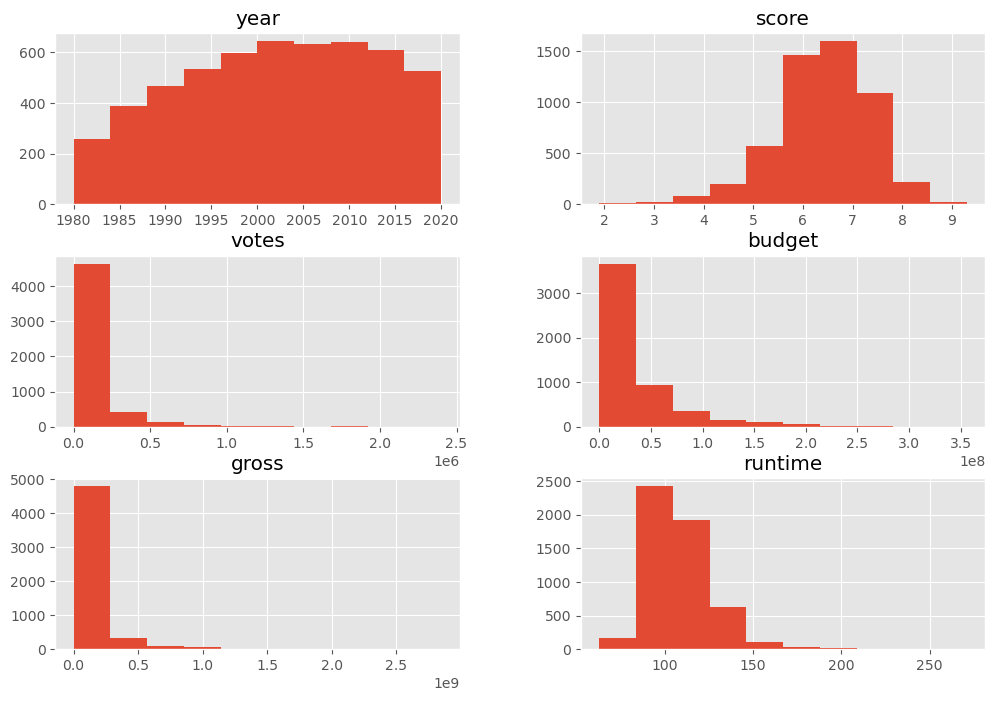

In [10]:
#distribution of numerical features
df.hist()

budget, votes, gross, runtime are skewed right

year has a very broad, slightly left skewed distribution

Text(0.5, 1.0, 'Budget Distribution in the Hundreds of Millions (100,000,000)')

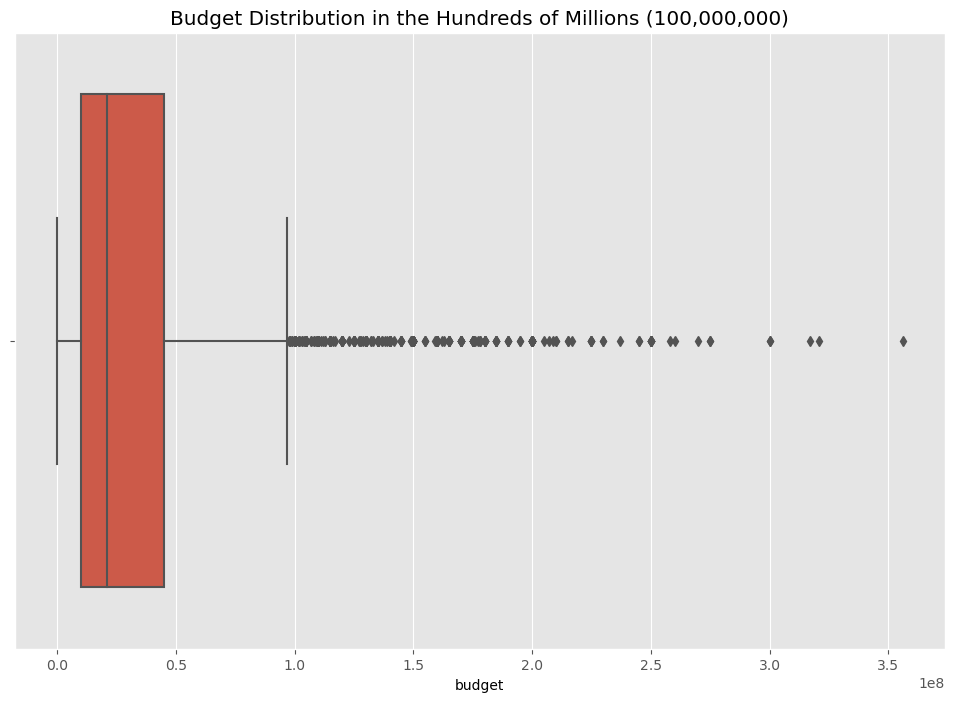

In [11]:
sns.boxplot(x=df['budget'])
plt.title('Budget Distribution in the Hundreds of Millions (100,000,000)')

Text(0.5, 1.0, 'Gross Distribution in the Billions (1,000,000,000)')

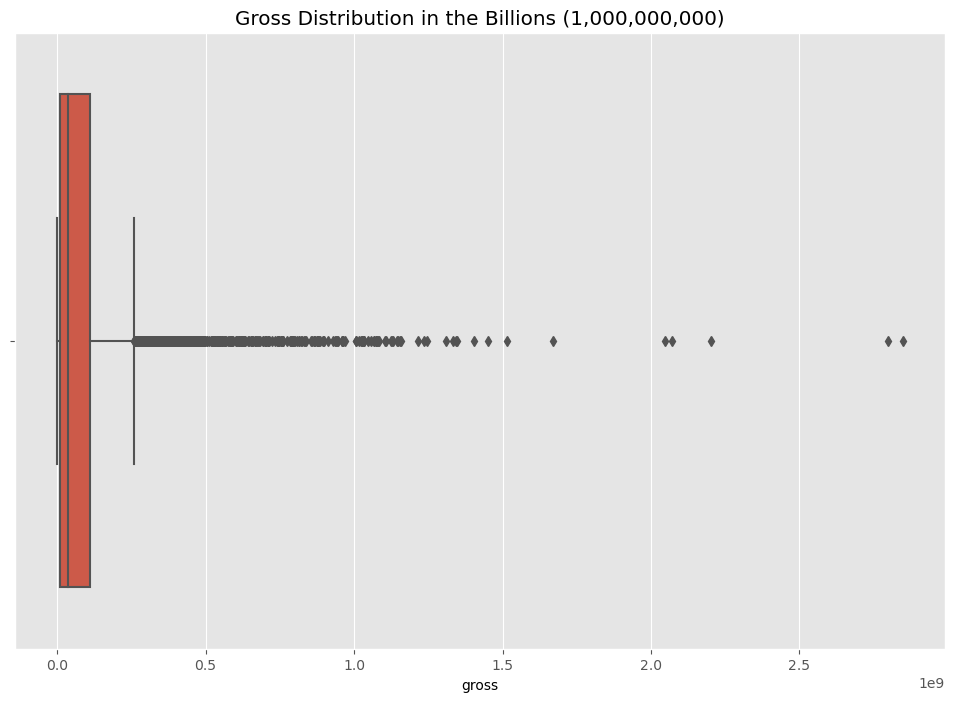

In [12]:
sns.boxplot(x=df['gross'])
plt.title('Gross Distribution in the Billions (1,000,000,000)')

## Number of films released per year ##

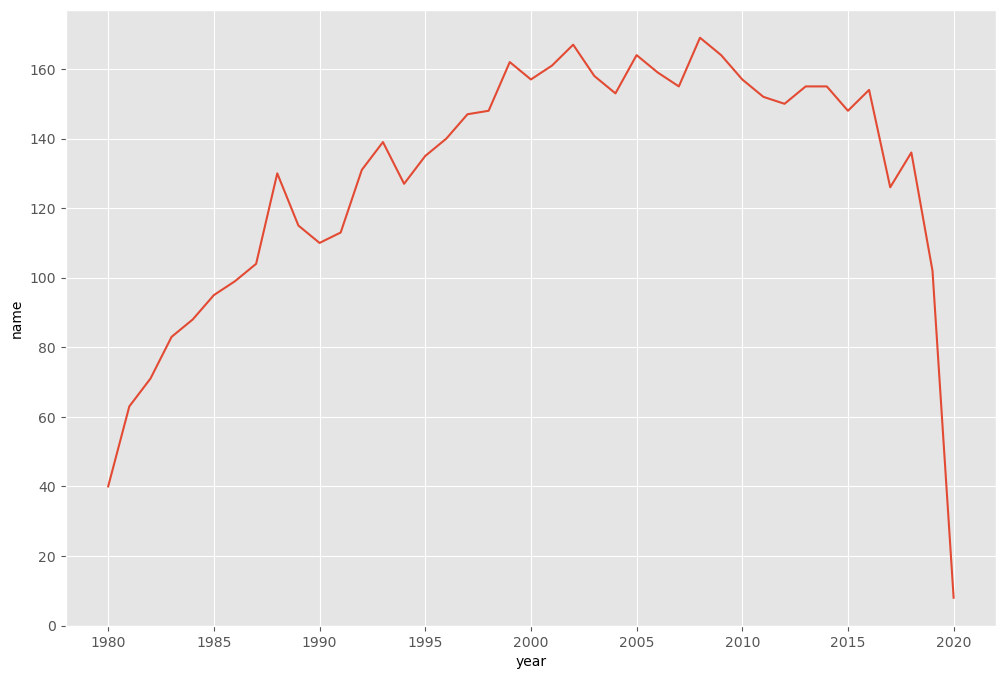

In [13]:
num_films = df.groupby('year')['name'].count()

a = sns.lineplot(num_films)
a.legend([],[], frameon=False)

## How have movie budgets and gross changed over the years?

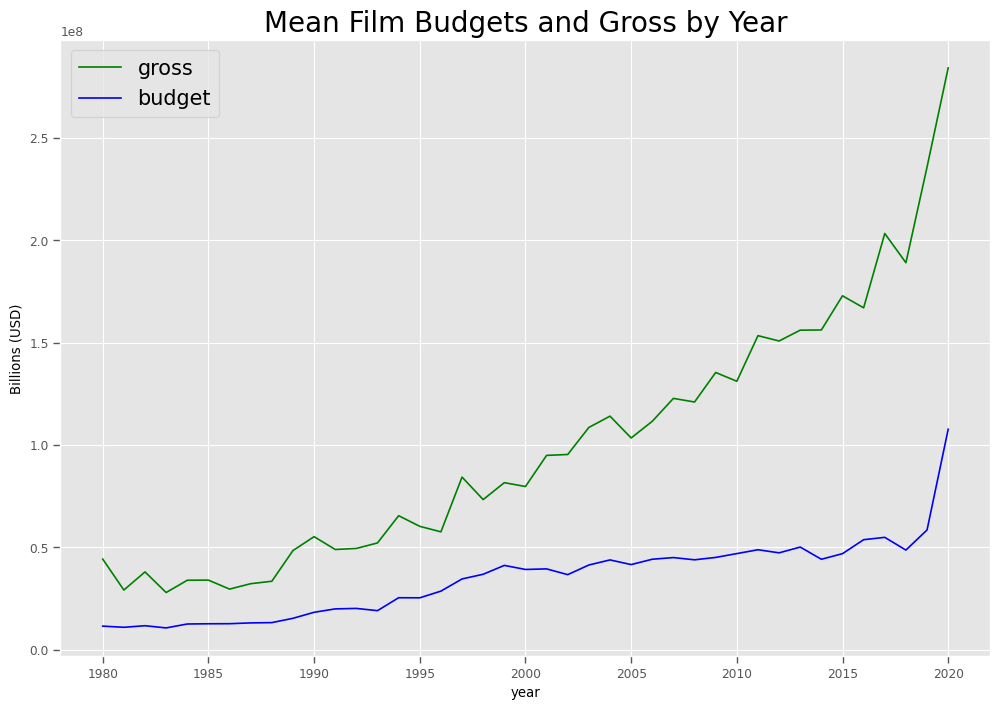

In [14]:
#summing gross by year
gross_over_yrs = df.groupby('year')[['gross']].mean()
gross_yr_sorted = gross_over_yrs.sort_values('year', ascending=False)

#summing budget by year
budget_over_yrs = df.groupby('year')[['budget']].mean()
budget_yr_sorted = budget_over_yrs.sort_values('year', ascending=False)


sns.set_context(context='paper')
g = sns.lineplot(gross_yr_sorted, palette=['g'])
b = sns.lineplot(budget_yr_sorted, palette=['b'])

#title and legend
plt.title('Mean Film Budgets and Gross by Year')
g.legend(fontsize=15)
b.legend(fontsize=15)
plt.ylabel('Billions (USD)')
g.title.set_size(20)

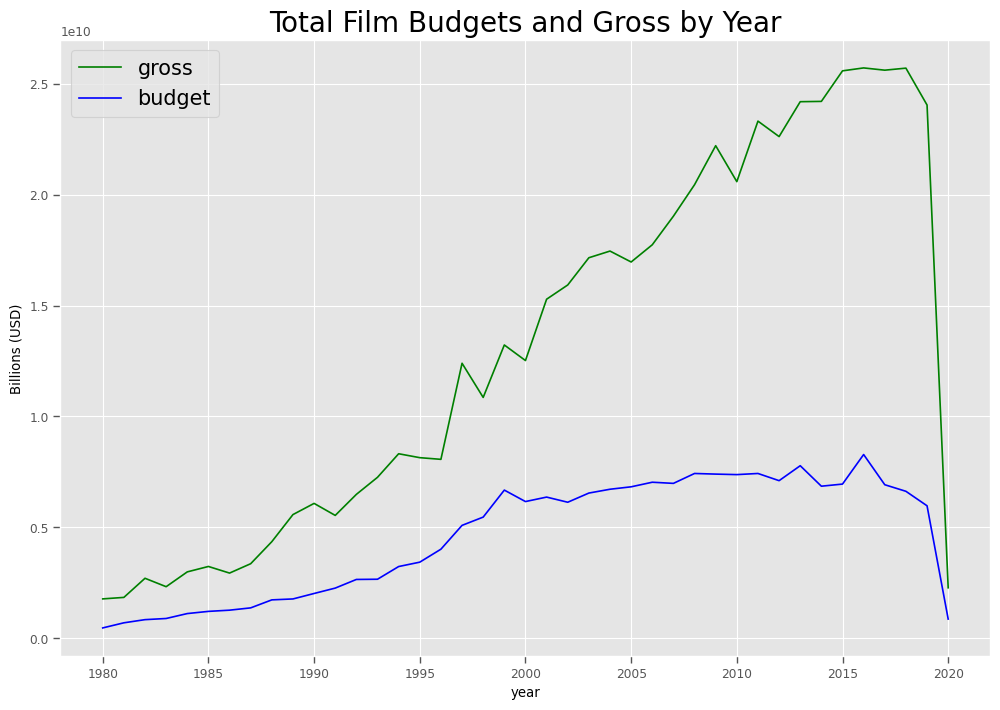

In [15]:
#summing gross by year
gross_over_yrs = df.groupby('year')[['gross']].sum()
gross_yr_sorted = gross_over_yrs.sort_values('year', ascending=False)

#summing budget by year
budget_over_yrs = df.groupby('year')[['budget']].sum()
budget_yr_sorted = budget_over_yrs.sort_values('year', ascending=False)


sns.set_context(context='paper')
g = sns.lineplot(gross_yr_sorted, palette=['g'])
b = sns.lineplot(budget_yr_sorted, palette=['b'])

#title and legend
plt.title('Total Film Budgets and Gross by Year')
g.legend(fontsize=15)
b.legend(fontsize=15)
plt.ylabel('Billions (USD)')
g.title.set_size(20)

## Distribution of movie genres

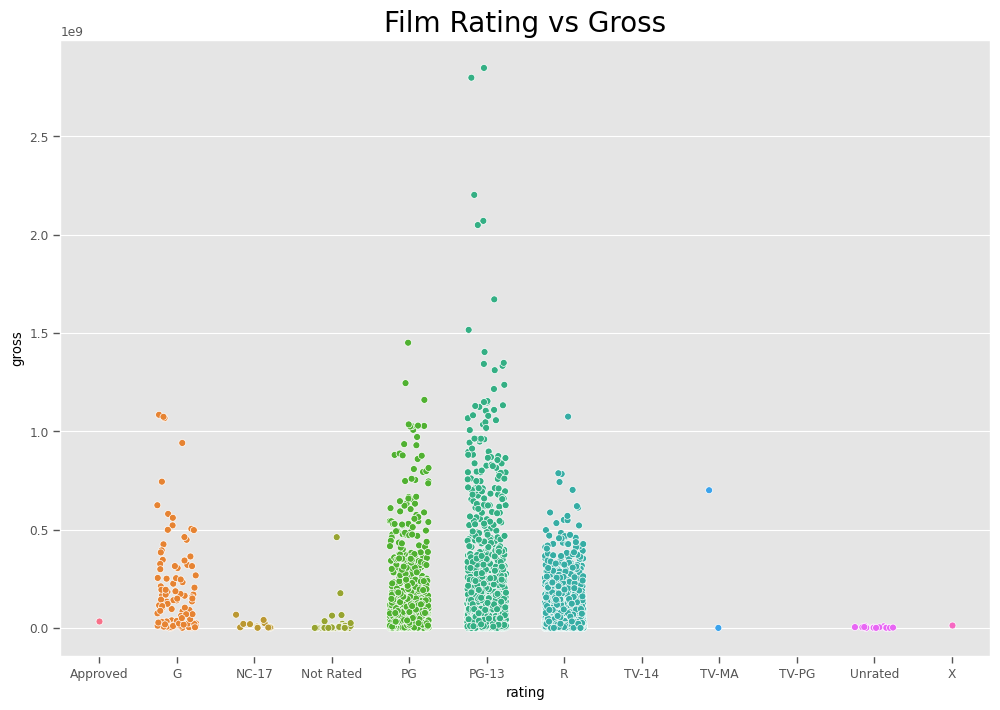

In [16]:
sns.set_context(context='paper')
axes = sns.stripplot(x='rating', y='gross', data=df, hue='rating', 
                     jitter=0.25, linewidth=0.5, edgecolor='white', legend=False)
plt.title('Film Rating vs Gross')
axes.title.set_size(20)

C:\Users\mflor\AppData\Local\Temp\ipykernel_11528\1833925099.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45)


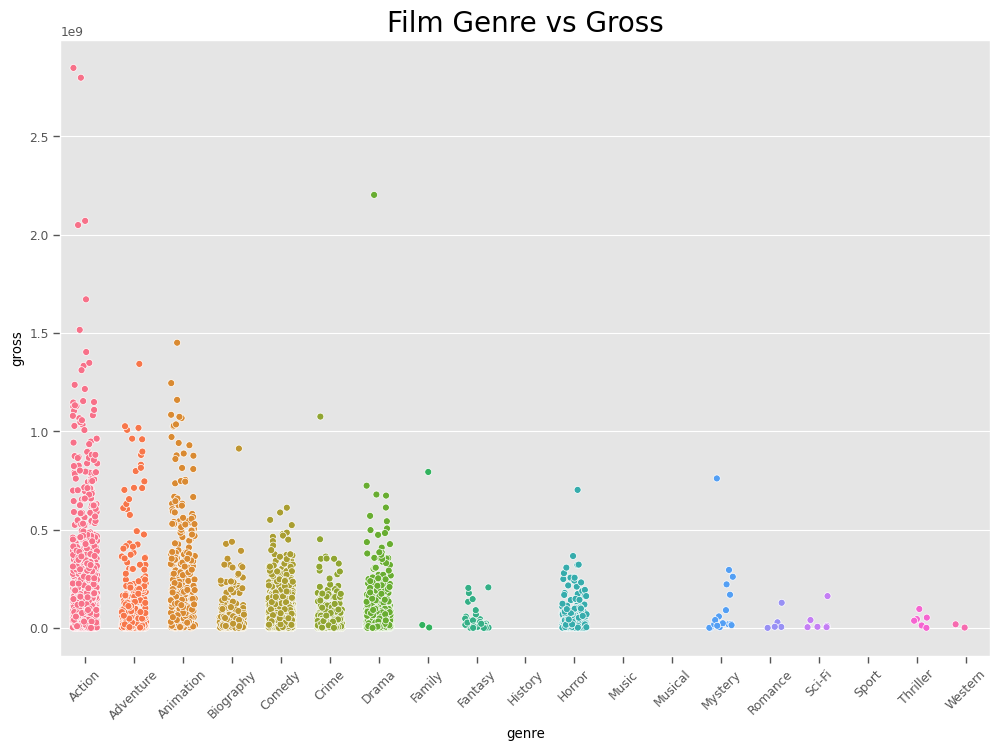

In [17]:
sns.set_context(context='paper')
axes = sns.stripplot(x='genre', y='gross', data=df, hue='genre', 
                     jitter=0.25, linewidth=0.5, edgecolor='white', legend=False)
plt.title('Film Genre vs Gross')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
axes.title.set_size(20)

## Which companies have released the most films?

In [18]:
#top 20 companies by number of films released
df['company'].value_counts()[:20]

Universal Pictures           326
Columbia Pictures            295
Warner Bros.                 293
Paramount Pictures           273
Twentieth Century Fox        205
New Line Cinema              149
Walt Disney Pictures         104
Touchstone Pictures          102
Metro-Goldwyn-Mayer (MGM)     94
TriStar Pictures              75
Dreamworks Pictures           72
Miramax                       63
Fox 2000 Pictures             55
Summit Entertainment          52
Screen Gems                   51
Lionsgate                     50
Fox Searchlight Pictures      48
Dimension Films               47
Orion Pictures                46
Castle Rock Entertainment     44
Name: company, dtype: int64

## What companies bring in the most revenue?

In [19]:
#top 20 companies by gross

company_gross = df.groupby('company')[['gross']].sum()
company_gross_sorted = company_gross.sort_values('gross', ascending=False)[:20]

company_gross_sorted

gross
company                                    
Warner Bros.                   5.324814e+10
Universal Pictures             5.025678e+10
Columbia Pictures              4.087009e+10
Paramount Pictures             3.882613e+10
Twentieth Century Fox          3.844517e+10
Walt Disney Pictures           3.285952e+10
New Line Cinema                1.874959e+10
Marvel Studios                 1.354678e+10
DreamWorks Animation           1.187361e+10
Dreamworks Pictures            1.092448e+10
Touchstone Pictures            1.048872e+10
Metro-Goldwyn-Mayer (MGM)      8.270701e+09
Pixar Animation Studios        7.886345e+09
Summit Entertainment           7.477015e+09
Lucasfilm                      7.185352e+09
Fox 2000 Pictures              6.966796e+09
Lionsgate                      5.825930e+09
Walt Disney Animation Studios  5.470001e+09
TriStar Pictures               5.405033e+09
Screen Gems                    3.842945e+09

## Creating an efficieny ratio for actors and directors
what actors and directors have the best average budget/gross 

In [20]:
def find_ratio(df):
    return df['gross']/df['budget']

In [21]:
actor_df = df[['star','name','budget','gross']].copy()

actor_df['ratio'] = actor_df.apply(find_ratio, axis=1)
print(actor_df['ratio'].isnull().sum())
actor_df.sort_values(by='ratio', ascending=False)[:20]

0


star                        name      budget        gross  \
3423  Katie Featherston         Paranormal Activity     15000.0  193355800.0   
2093    Heather Donahue     The Blair Witch Project     60000.0  248639099.0   
4749      Reese Mishler                 The Gallows    100000.0   42964410.0   
1155    Carlos Gallardo                 El Mariachi      7000.0    2040920.0   
3455       Glen Hansard                        Once    150000.0   20936722.0   
1402   Brian O'Halloran                      Clerks     27000.0    3151130.0   
2907          Jon Heder           Napoleon Dynamite    400000.0   46138887.0   
1927      Aaron Eckhart       In the Company of Men     25000.0    2804473.0   
3181     Rowan Atkinson                 Keeping Mum    169000.0   18586834.0   
2785     Blanchard Ryan                  Open Water    500000.0   54683487.0   
4303   Fernanda Andrade            The Devil Inside   1000000.0  101758490.0   
4600       Jared Harris              The Quiet Ones    200000.0   17835162.0   
2896         Cary Elwes                         Saw   1200000.0  103911669.0   
5118           John Cho                   Searching    880000.0   75462037.0   
2938      Shane Carruth                      Primer      7000.0     545436.0   
107        Henry Thomas  E.T. the Extra-Terrestrial  10500000.0  792910554.0   
2591       Nia Vardalos    My Big Fat Greek Wedding   5000000.0  368744044.0   
1825     Robert Carlyle              The Full Monty   3500000.0  257938649.0   
5          Betsy Palmer             Friday the 13th    550000.0   39754601.0   
3657       Kirk Cameron                   Fireproof    500000.0   33473297.0   

             ratio  
3423  12890.386667  
2093   4143.984983  
4749    429.644100  
1155    291.560000  
3455    139.578147  
1402    116.708519  
2907    115.347217  
1927    112.178920  
3181    109.981266  
2785    109.366974  
4303    101.758490  
4600     89.175810  
2896     86.593058  
5118     85.752315  
2938     77.919429  
107      75.515291  
2591     73.748809  
1825     73.696757  
5        72.281093  
3657     66.946594

In [22]:
#finding an actor's average ratio of their film's budget/gross and assigning that as their efficieny value
actor_efficiency = actor_df.groupby('star')[['ratio']].mean()
actor_efficiency = actor_efficiency.dropna()
actor_efficiency.sort_values(by='ratio', ascending=False)[:20]

ratio
star                          
Katie Featherston  6474.778672
Heather Donahue    4143.984983
Reese Mishler       429.644100
Carlos Gallardo     291.560000
Glen Hansard        139.578147
Jon Heder           115.347217
Blanchard Ryan      109.366974
Fernanda Andrade    101.758490
Jared Harris         89.175810
Shane Carruth        77.919429
Henry Thomas         75.515291
Robert Carlyle       73.696757
Heather Sossaman     62.882090
Brian O'Halloran     61.052877
Daniel Kaluuya       56.797590
Sean Gullette        53.685867
Richard Linklater    53.396000
Samy Naceri          50.382468
Payman Maadi         45.852152
Betsy Palmer         44.829657

In [23]:
#directors efficiency ratio
director_df = df[['director','name','budget','gross']].copy()

director_df['ratio'] = director_df.apply(find_ratio, axis=1)

director_efficiency = director_df.groupby('director')[['ratio']].mean()
director_efficiency = director_efficiency.dropna()
director_efficiency.sort_values(by='ratio', ascending=False)[:20]

ratio
director                        
Oren Peli           12890.386667
Daniel Myrick        4143.984983
Travis Cluff          429.644100
Niall Johnson         109.981266
John Pogue             89.175810
Aneesh Chaganty        85.752315
John Carney            73.892380
Levan Gabriadze        62.882090
Chris Kentis           58.815424
Gérard Krawczyk        50.382468
Robert C. Ramirez      46.506086
Shane Carruth          44.831454
Jared Hess             39.398312
Daniel Stamm           38.573626
Bradley Parker         38.390020
Joel Zwick             37.808084
William Brent Bell     37.683748
Peter Cattaneo         37.142010
Sean S. Cunningham     36.649498
Jordan Peele           34.778410

In [24]:
#actors with the highest cumulative gross
top_20_actor = actor_df.groupby('star')[['gross']].sum().sort_values(by='gross',ascending=False)[:20]
top_20_actor

gross
star                               
Robert Downey Jr.      1.033712e+10
Tom Hanks              9.899945e+09
Tom Cruise             9.031078e+09
Johnny Depp            7.410125e+09
Daniel Radcliffe       6.971268e+09
Leonardo DiCaprio      6.749648e+09
Vin Diesel             6.036313e+09
Will Smith             5.937777e+09
Bruce Willis           5.318951e+09
Chris Pratt            5.278456e+09
Ben Stiller            5.246015e+09
Dwayne Johnson         5.038423e+09
Adam Sandler           4.949567e+09
Harrison Ford          4.897078e+09
Daisy Ridley           4.480695e+09
Jim Carrey             4.463263e+09
Mark Wahlberg          4.326734e+09
Sandra Bullock         4.245823e+09
Arnold Schwarzenegger  4.196938e+09
Brad Pitt              4.156175e+09

In [25]:
#directors with the highest cumulative gross
top_20_dir = director_df.groupby('director')[['gross']].sum().sort_values(by='gross',ascending=False)[:20]
top_20_dir

gross
director                       
Steven Spielberg   9.629049e+09
Anthony Russo      6.844249e+09
Peter Jackson      6.618046e+09
James Cameron      6.248089e+09
Michael Bay        6.147337e+09
David Yates        5.044548e+09
Christopher Nolan  5.039789e+09
J.J. Abrams        4.659375e+09
Tim Burton         4.456349e+09
Ron Howard         4.291110e+09
Robert Zemeckis    4.286714e+09
Chris Columbus     3.969413e+09
Gore Verbinski     3.753025e+09
Bryan Singer       3.728453e+09
James Wan          3.710651e+09
Ridley Scott       3.541335e+09
Brad Bird          3.426902e+09
Francis Lawrence   3.363675e+09
Sam Raimi          3.288039e+09
Clint Eastwood     3.275522e+09

## What relationships exist in the data - correlations ## 

In [26]:
#pearsonr takes arrays
year = df.loc[:,'year'].values
score = df.loc[:,'score'].values
votes = df.loc[:,'votes'].values
budget = df.loc[:,'budget'].values
gross = df.loc[:,'gross'].values
runtime = df.loc[:,'runtime'].values

### choosing between parametric and nonparametric correlation test ##

<Axes: xlabel='budget', ylabel='gross'>

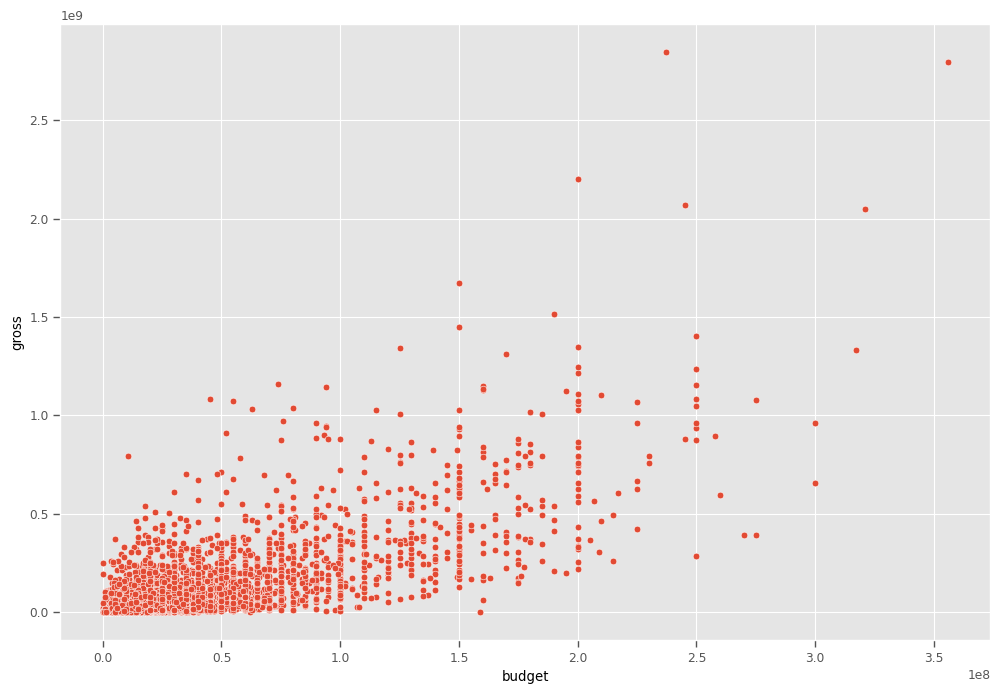

In [27]:
#determining linearity in order to choose between pearson vs spearman vs kendall correlation
sns.scatterplot(data=df, x='budget',y='gross')

considering that the distributions of the data are not normally distributed and the relationship between gross and budget seems more monotonic, I chose to do a non parametric test

Schober, Boer, and Schwarte (2018)

very strong: >=0.71, strong: 0.49 to 0.7, moderate: 0.48 to 0.26, weak: 0.25 to 0.06

<Axes: >

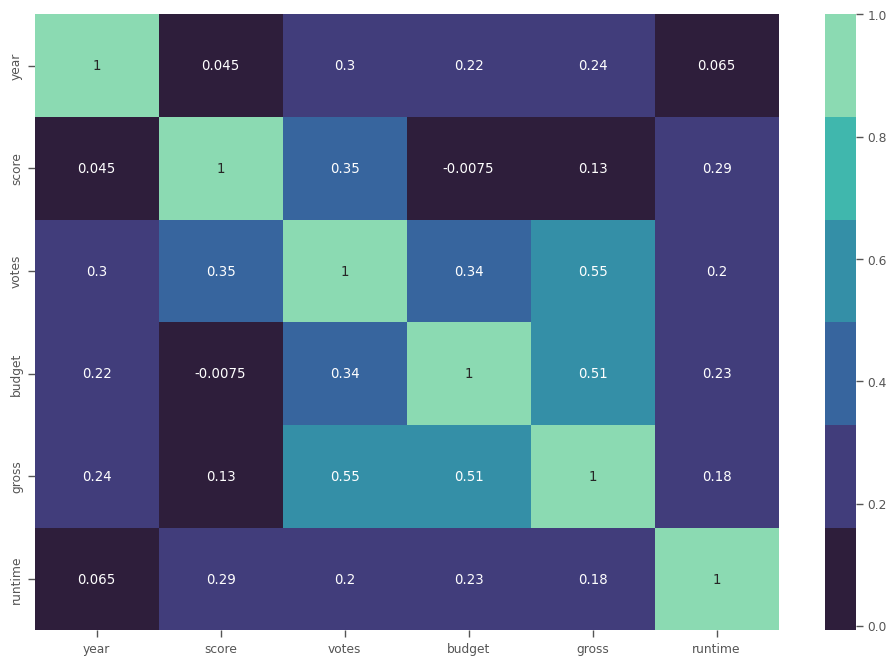

In [28]:
#kendall correlation
corr_mat = df.corr(numeric_only=True, method='kendall')
sns.heatmap(corr_mat, annot=True, cmap=sns.color_palette('mako'))

In [29]:
#unstacking the correlation matrix to find the strongest relationships
corr_pairs = corr_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind='quicksort',ascending=False)

In [30]:
#sorting the relationships
pairs = sorted_pairs[abs(sorted_pairs) < 1.00]
pairs = pairs[::2] #to get no duplicates


strong_pairs = pairs[abs(pairs) >= 0.49]

moderate_pairs = pairs[abs(pairs) < 0.49]
moderate_pairs = moderate_pairs[abs(moderate_pairs) >= 0.26]

weak_pairs = pairs[abs(pairs) >= 0.06]
weak_pairs = weak_pairs[abs(weak_pairs) < 0.25]

negligible = pairs[abs(pairs) < 0.06]

print(f'''Strong relationships:\n{strong_pairs} 
        Moderate relationships: \n{moderate_pairs} 
        Weak relationships: \n{weak_pairs}
        Negligible relationships: \n{negligible}''')

Strong relationships:
gross   votes    0.552302
budget  gross    0.511208
dtype: float64 
        Moderate relationships: 
score    votes    0.351581
budget   votes    0.342514
votes    year     0.298663
runtime  score    0.290888
dtype: float64 
        Weak relationships: 
gross   year       0.237243
budget  runtime    0.229902
year    budget     0.220187
votes   runtime    0.202152
gross   runtime    0.175203
        score      0.125769
year    runtime    0.064793
dtype: float64
        Negligible relationships: 
year    score    0.045157
budget  score   -0.007477
dtype: float64


## Calculating the p-values for correlation pairs

In [31]:
print('===Strong correlation (0.50-0.71)===')
print(f'gross and votes: {kendalltau(gross, votes)}')
print(f'gross and budget: {kendalltau(gross, budget)}')
print('===Moderate correlation (0.26-0.49)===')
print(f'score and votes: {kendalltau(score, votes)}')
print(f'budget and votes: {kendalltau(budget, votes)}')
print(f'votes and year: {kendalltau(votes, year)}')
print(f'runtime and score: {kendalltau(runtime, score)}')
print('===Weak correlation (<0.26)===')
print(f'score and votes: {kendalltau(score, votes)}')
print(f'budget and votes: {kendalltau(budget, votes)}')
print(f'runtime and score: {kendalltau(runtime, score)}')

===Strong correlation (0.50-0.71)===
gross and votes: SignificanceResult(statistic=0.552302261035414, pvalue=0.0)
gross and budget: SignificanceResult(statistic=0.5112083235524761, pvalue=0.0)
===Moderate correlation (0.26-0.49)===
score and votes: SignificanceResult(statistic=0.35158054262546107, pvalue=0.0)
budget and votes: SignificanceResult(statistic=0.3425140581929299, pvalue=4.862757601503021e-299)
votes and year: SignificanceResult(statistic=0.29866265405634435, pvalue=6.822429700437744e-226)
runtime and score: SignificanceResult(statistic=0.2908875456198602, pvalue=1.6405204129894813e-210)
===Weak correlation (<0.26)===
score and votes: SignificanceResult(statistic=0.35158054262546107, pvalue=0.0)
budget and votes: SignificanceResult(statistic=0.3425140581929299, pvalue=4.862757601503021e-299)
runtime and score: SignificanceResult(statistic=0.2908875456198602, pvalue=1.6405204129894813e-210)


In [32]:
#calculate t-stastic 
r = kendalltau(gross,budget)[0]
n = len(gross)
t = (r * np.sqrt(n-2))/np.sqrt(1-r**2)
print(t)

43.2533321547865


## Predicting movie performance using simple linear regression

In [33]:
X = df['budget']
# X = sm.add_constant(X)
y = df['gross']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

y_pred = model.predict(X)
y_bar = np.mean(y)

SSR = np.sum(np.square(y_pred - y_bar))
SSE = np.sum(np.square(y-y_pred))
SST = np.sum(np.square(y-y_bar))

r_squared_bg = round(SSR/SST,3)

print(r_squared_bg)
print(model.summary())

0.546
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     6354.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:44   Log-Likelihood:            -1.0608e+05
No. Observations:                5290   AIC:                         2.122e+05
Df Residuals:                    5288   BIC:                         2.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.563e+07   2.25e+06     -6.957   

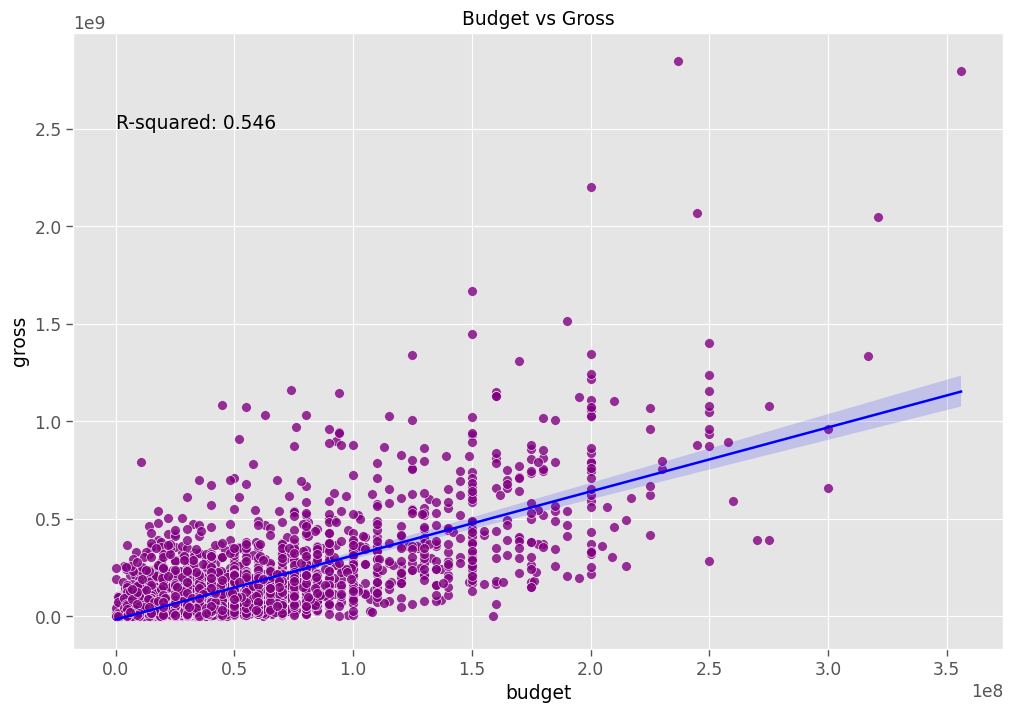

In [34]:
#budget vs gross
sns.set_context('paper', font_scale=1.4)
g = sns.regplot(x='budget', y='gross', data=df, ci=95, x_jitter=0.05,
               scatter_kws={'s': 50, 'linewidth': 0.5, 'edgecolor': 'w', 'color': 'purple'},
              line_kws={'color': 'blue'})
plt.title('Budget vs Gross')
g.annotate(f'R-squared: {r_squared_bg}',(0,2500000000))
plt.show()

In [35]:
#votes vs gross
X = df['votes']
# X = sm.add_constant(X)
y = df['gross']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

y_pred = model.predict(X)
y_bar = np.mean(y)

SSR = np.sum(np.square(y_pred - y_bar))
SSE = np.sum(np.square(y-y_pred))
SST = np.sum(np.square(y-y_bar))

r_squared_vg = round(SSR/SST,3)

print(r_squared_vg)
print(model.summary())

0.381
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3250.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:45   Log-Likelihood:            -1.0690e+05
No. Observations:                5290   AIC:                         2.138e+05
Df Residuals:                    5288   BIC:                         2.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.098e+07   2.34e+06     13.247   

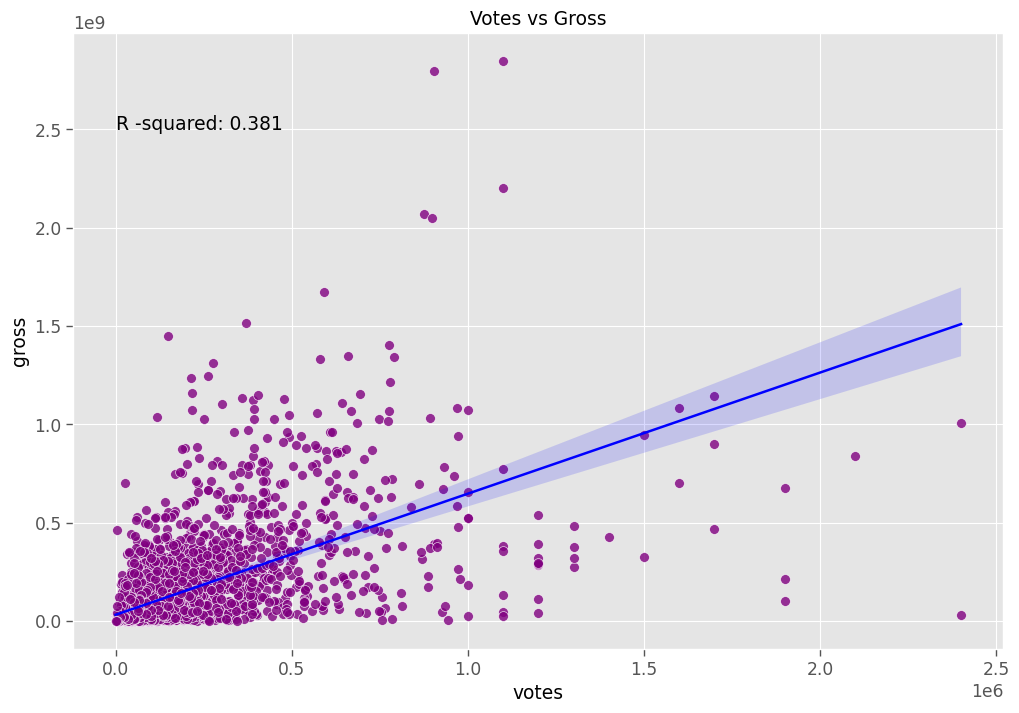

In [36]:
#budget vs gross
sns.set_context('paper', font_scale=1.4)
g = sns.regplot(x='votes', y='gross', data=df, ci=95, x_jitter=0.05,
               scatter_kws={'s': 50, 'linewidth': 0.5, 'edgecolor': 'w', 'color': 'purple'},
              line_kws={'color': 'blue'})

plt.title('Votes vs Gross')
g.annotate(f'R -squared: {r_squared_vg}',(0,2500000000))
plt.show()

# Predicting movie gross using multivariate linear regression #

## normalizing the data ##

In [37]:
#normalize the features
norm = df[['budget','gross','votes','score','runtime']].copy()
norm = Normalizer().fit_transform(norm)

budget = norm[:,0]
gross = norm[:,1]
votes = norm[:,2]
score = norm[:,3]
runtime = norm[:,4]
norm_df = pd.DataFrame()

norm_df['budget'] = budget
norm_df['gross'] = gross
norm_df['votes'] = votes
norm_df['score'] = score
norm_df['runtime'] = runtime
norm_df['year'] = df['year']

norm_df

budget     gross     votes         score       runtime  year
0     0.374735  0.926952  0.018283  1.656723e-07  2.879542e-06  1980
1     0.076239  0.997089  0.001101  9.826356e-08  1.761967e-06  1980
2     0.033415  0.999439  0.002228  1.615067e-08  2.301935e-07  1980
3     0.041903  0.999118  0.002646  9.218555e-08  1.053549e-06  1980
4     0.148899  0.988849  0.002680  1.811608e-07  2.432022e-06  1980
...        ...       ...       ...           ...           ...   ...
5285  0.206470  0.978453  0.000321  1.514117e-08  2.844705e-07  2020
5286  0.256936  0.966428  0.000308  1.964803e-08  2.992547e-07  2020
5287  0.580473  0.814280  0.000176  1.857513e-08  3.350157e-07  2020
5288  0.772129  0.635465  0.000240  3.889244e-08  5.719477e-07  2020
5289  0.170829  0.985301  0.000008  1.452044e-08  3.181685e-07  2020

[5290 rows x 6 columns]

multivariate improved model performance by 10%
normalizing the dataset improved model performance by ~20% more

## including one-hot-encoding for select categorical features ##

In [38]:
norm_df['genre'] = df['genre']
norm_df['rating'] = df['rating']
norm_df

budget     gross     votes         score       runtime  year  \
0     0.374735  0.926952  0.018283  1.656723e-07  2.879542e-06  1980   
1     0.076239  0.997089  0.001101  9.826356e-08  1.761967e-06  1980   
2     0.033415  0.999439  0.002228  1.615067e-08  2.301935e-07  1980   
3     0.041903  0.999118  0.002646  9.218555e-08  1.053549e-06  1980   
4     0.148899  0.988849  0.002680  1.811608e-07  2.432022e-06  1980   
...        ...       ...       ...           ...           ...   ...   
5285  0.206470  0.978453  0.000321  1.514117e-08  2.844705e-07  2020   
5286  0.256936  0.966428  0.000308  1.964803e-08  2.992547e-07  2020   
5287  0.580473  0.814280  0.000176  1.857513e-08  3.350157e-07  2020   
5288  0.772129  0.635465  0.000240  3.889244e-08  5.719477e-07  2020   
5289  0.170829  0.985301  0.000008  1.452044e-08  3.181685e-07  2020   

          genre     rating  
0         Drama          R  
1     Adventure          R  
2        Action         PG  
3        Comedy         PG  
4        Comedy          R  
...         ...        ...  
5285     Action          R  
5286     Action         PG  
5287  Adventure         PG  
5288  Adventure         PG  
5289     Action  Not Rated  

[5290 rows x 8 columns]

In [39]:
#one-hot-encoding of film genres and ratings
cat_cols = ['genre','rating']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(norm_df[cat_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_cols))
df_encoded = pd.concat([norm_df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(cat_cols, axis=1)


In [40]:
pd.set_option('display.max_columns', None)
df_encoded

budget     gross     votes         score       runtime  year  \
0     0.374735  0.926952  0.018283  1.656723e-07  2.879542e-06  1980   
1     0.076239  0.997089  0.001101  9.826356e-08  1.761967e-06  1980   
2     0.033415  0.999439  0.002228  1.615067e-08  2.301935e-07  1980   
3     0.041903  0.999118  0.002646  9.218555e-08  1.053549e-06  1980   
4     0.148899  0.988849  0.002680  1.811608e-07  2.432022e-06  1980   
...        ...       ...       ...           ...           ...   ...   
5285  0.206470  0.978453  0.000321  1.514117e-08  2.844705e-07  2020   
5286  0.256936  0.966428  0.000308  1.964803e-08  2.992547e-07  2020   
5287  0.580473  0.814280  0.000176  1.857513e-08  3.350157e-07  2020   
5288  0.772129  0.635465  0.000240  3.889244e-08  5.719477e-07  2020   
5289  0.170829  0.985301  0.000008  1.452044e-08  3.181685e-07  2020   

      genre_Action  genre_Adventure  genre_Animation  genre_Biography  \
0              0.0              0.0              0.0              0.0   
1              0.0              1.0              0.0              0.0   
2              1.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   
...            ...              ...              ...              ...   
5285           1.0              0.0              0.0              0.0   
5286           1.0              0.0              0.0              0.0   
5287           0.0              1.0              0.0              0.0   
5288           0.0              1.0              0.0              0.0   
5289           1.0              0.0              0.0              0.0   

      genre_Comedy  genre_Crime  genre_Drama  genre_Family  genre_Fantasy  \
0              0.0          0.0          1.0           0.0            0.0   
1              0.0          0.0          0.0           0.0            0.0   
2              0.0          0.0          0.0           0.0            0.0   
3              1.0          0.0          0.0           0.0            0.0   
4              1.0          0.0          0.0           0.0            0.0   
...            ...          ...          ...           ...            ...   
5285           0.0          0.0          0.0           0.0            0.0   
5286           0.0          0.0          0.0           0.0            0.0   
5287           0.0          0.0          0.0           0.0            0.0   
5288           0.0          0.0          0.0           0.0            0.0   
5289           0.0          0.0          0.0           0.0            0.0   

      genre_Horror  genre_Mystery  genre_Romance  genre_Sci-Fi  \
0              0.0            0.0            0.0           0.0   
1              0.0            0.0            0.0           0.0   
2              0.0            0.0            0.0           0.0   
3              0.0            0.0            0.0           0.0   
4              0.0            0.0            0.0           0.0   
...            ...            ...            ...           ...   
5285           0.0            0.0            0.0           0.0   
5286           0.0            0.0            0.0           0.0   
5287           0.0            0.0            0.0           0.0   
5288           0.0            0.0            0.0           0.0   
5289           0.0            0.0            0.0           0.0   

      genre_Thriller  genre_Western  rating_Approved  rating_G  rating_NC-17  \
0                0.0            0.0              0.0       0.0           0.0   
1                0.0            0.0              0.0       0.0           0.0   
2                0.0            0.0              0.0       0.0           0.0   
3                0.0            0.0              0.0       0.0           0.0   
4                0.0            0.0              0.0       0.0           0.0   
...              ...            ...              ...       ...      

# Building the model #

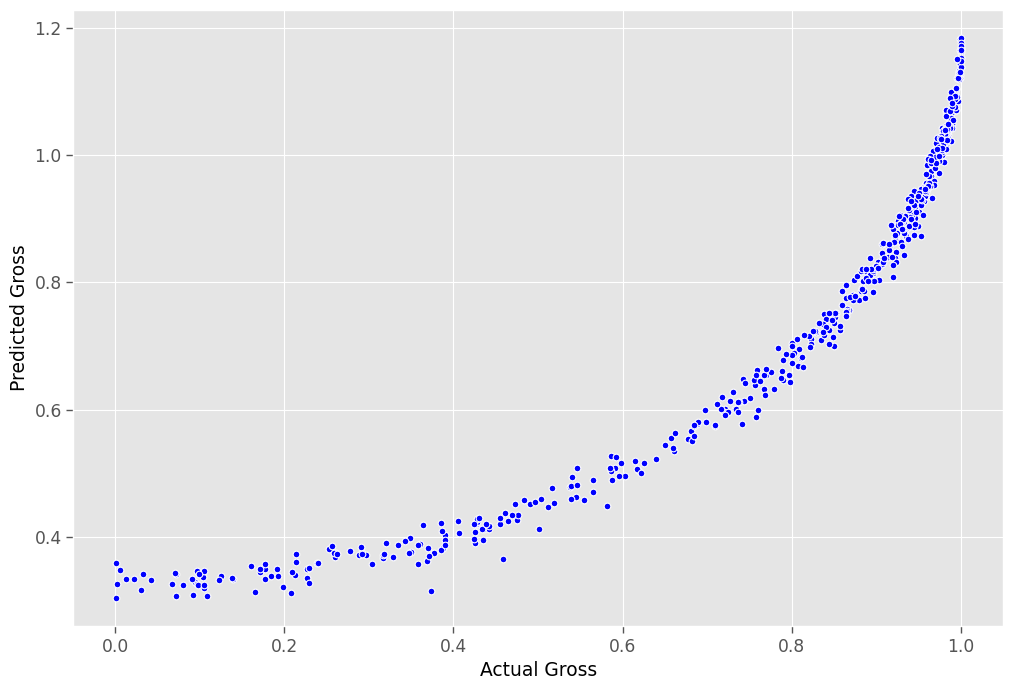

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1022.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:48   Log-Likelihood:                 3908.2
No. Observations:                4761   AIC:                            -7758.
Df Residuals:                    4732   BIC:                            -7571.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0051      0.270  

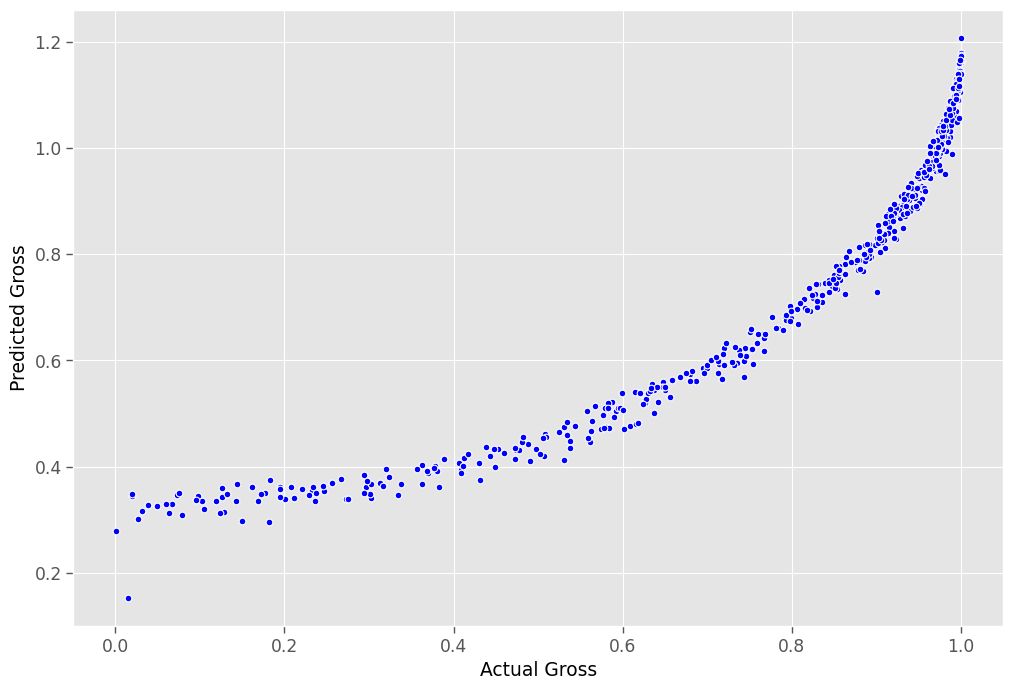

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1025.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3891.6
No. Observations:                4761   AIC:                            -7725.
Df Residuals:                    4732   BIC:                            -7538.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0632      0.273  

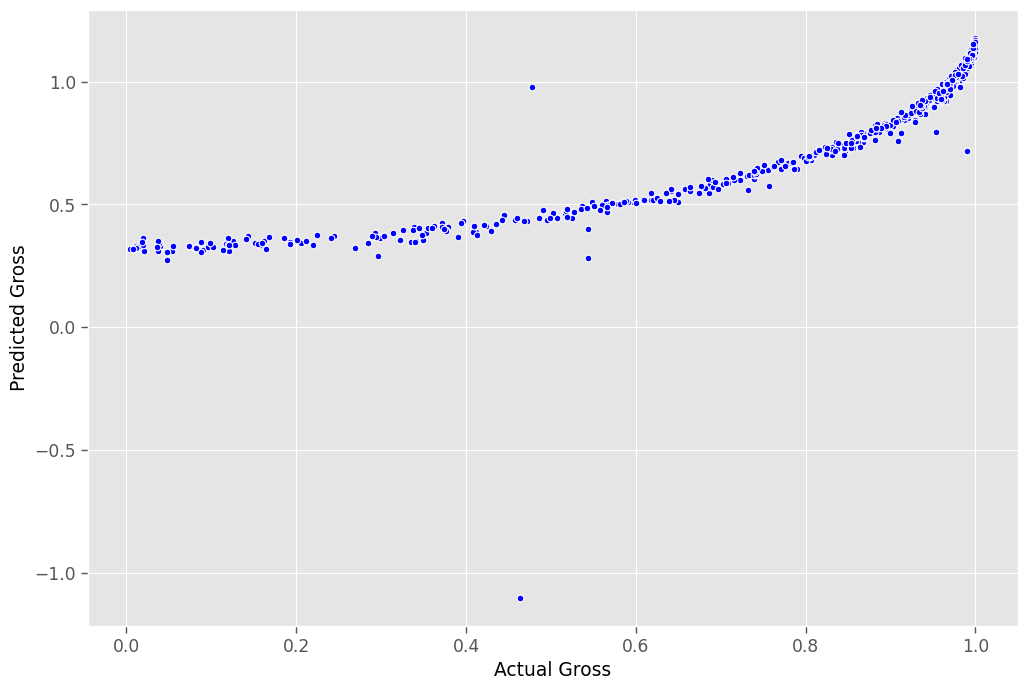

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     1042.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3964.9
No. Observations:                4761   AIC:                            -7872.
Df Residuals:                    4732   BIC:                            -7684.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2463      0.267  

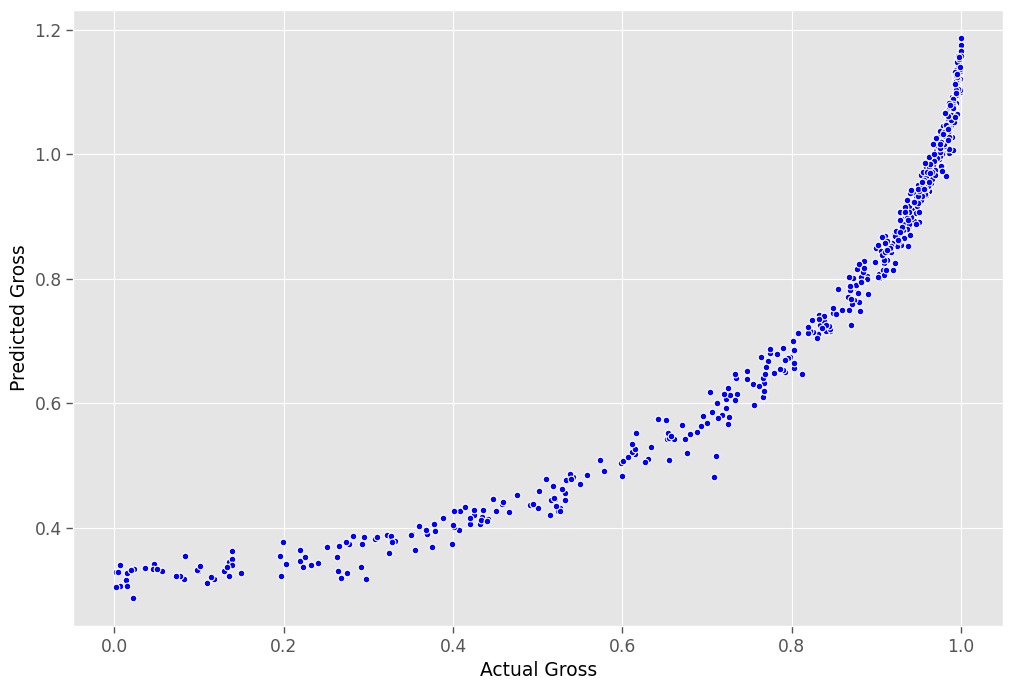

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1065.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3909.6
No. Observations:                4761   AIC:                            -7763.
Df Residuals:                    4733   BIC:                            -7582.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0849      0.269  

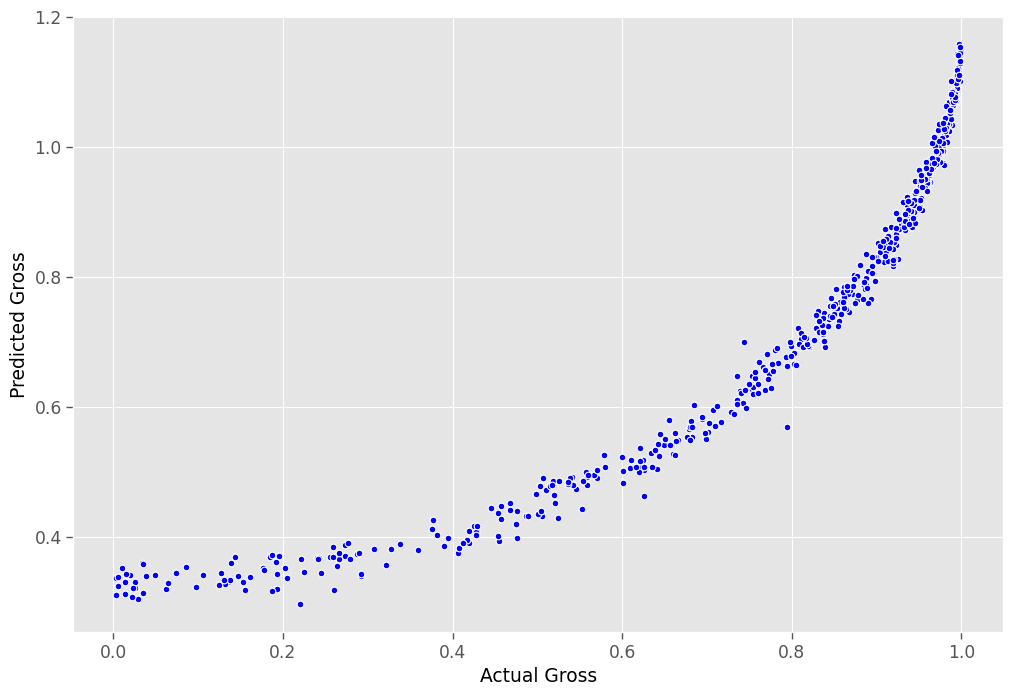

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1038.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3935.0
No. Observations:                4761   AIC:                            -7812.
Df Residuals:                    4732   BIC:                            -7624.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1175      0.270  

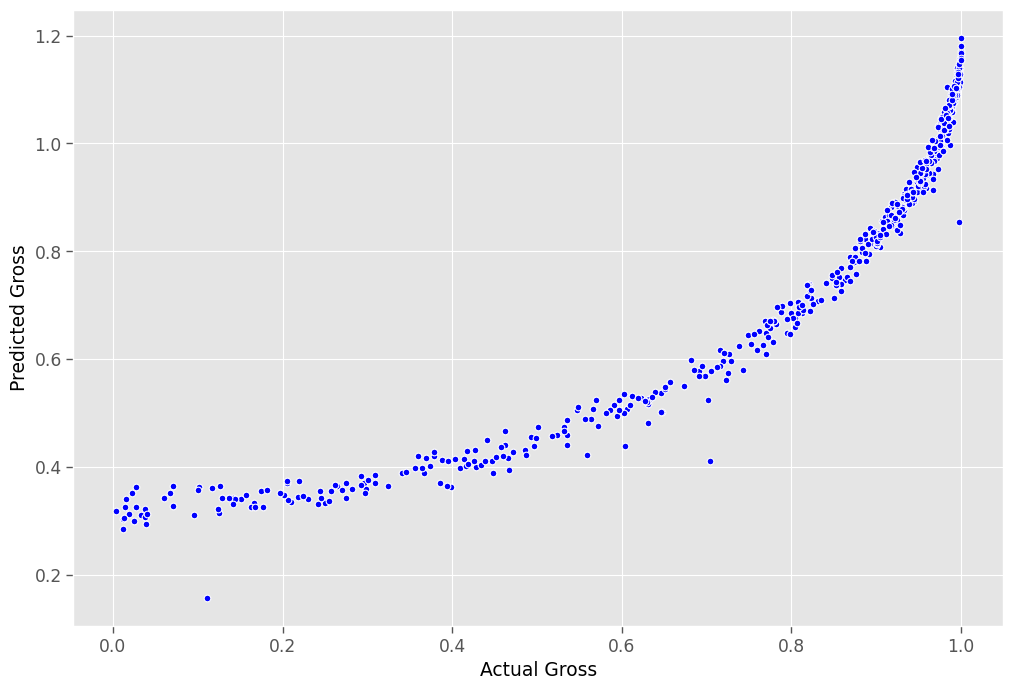

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1023.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3915.9
No. Observations:                4761   AIC:                            -7774.
Df Residuals:                    4732   BIC:                            -7586.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0043      0.270  

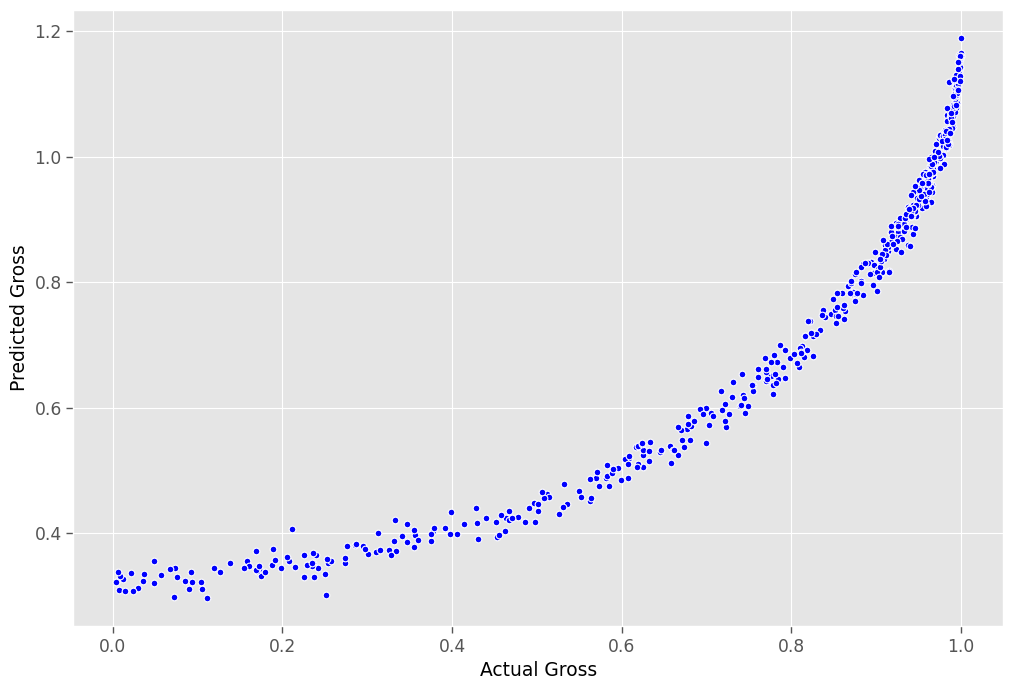

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1024.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3917.2
No. Observations:                4761   AIC:                            -7776.
Df Residuals:                    4732   BIC:                            -7589.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0401      0.270  

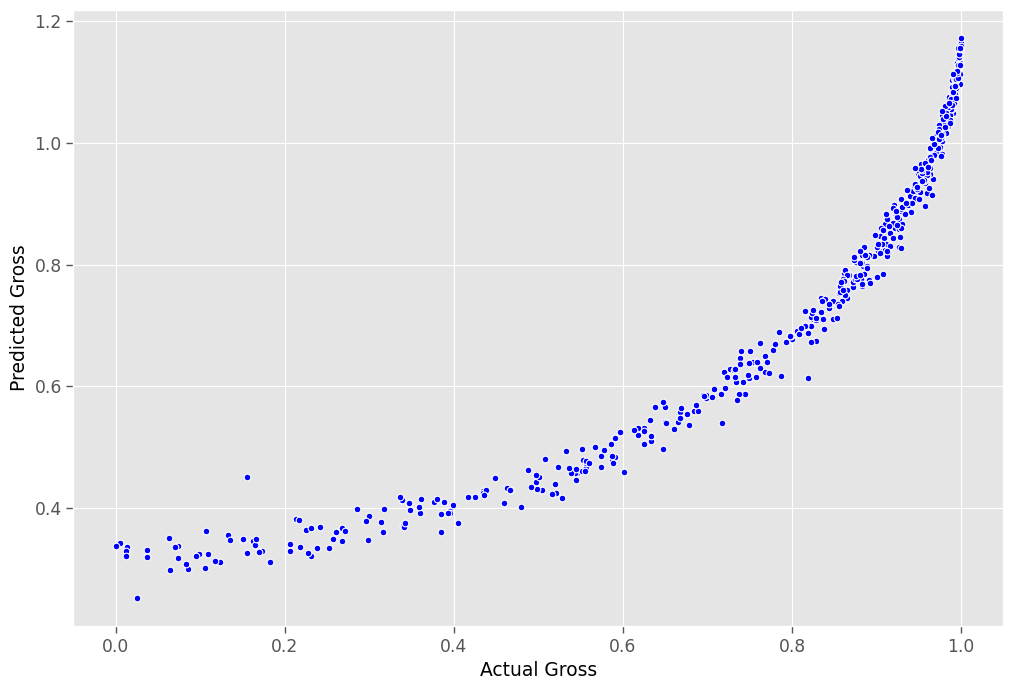

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1036.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:49   Log-Likelihood:                 3909.1
No. Observations:                4761   AIC:                            -7760.
Df Residuals:                    4732   BIC:                            -7573.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0827      0.270  

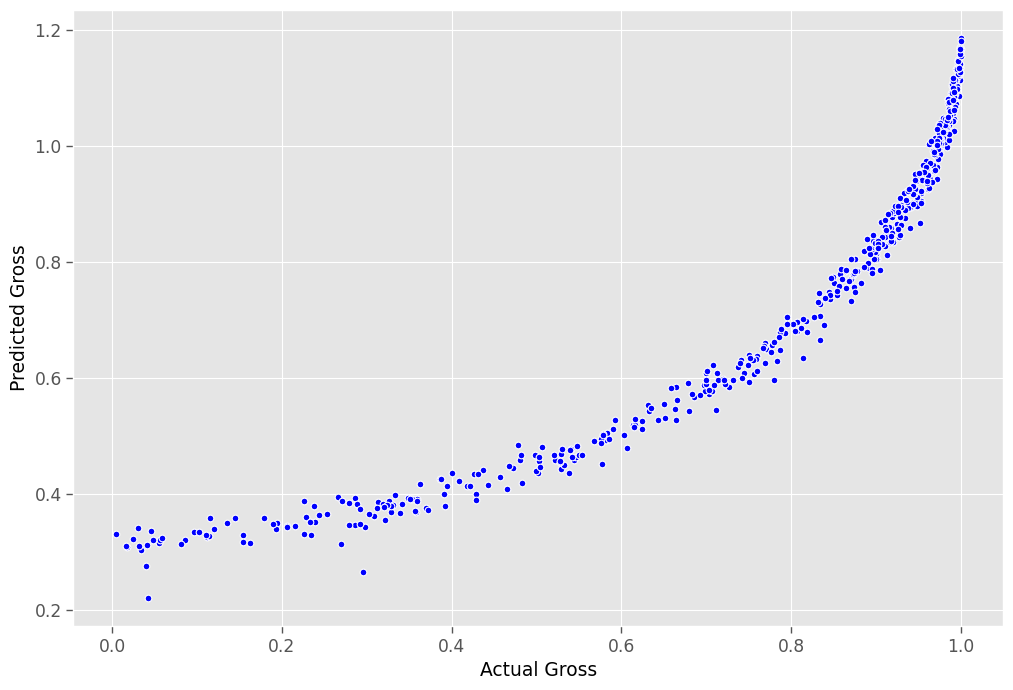

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1060.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:50   Log-Likelihood:                 3895.0
No. Observations:                4761   AIC:                            -7734.
Df Residuals:                    4733   BIC:                            -7553.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1650      0.269  

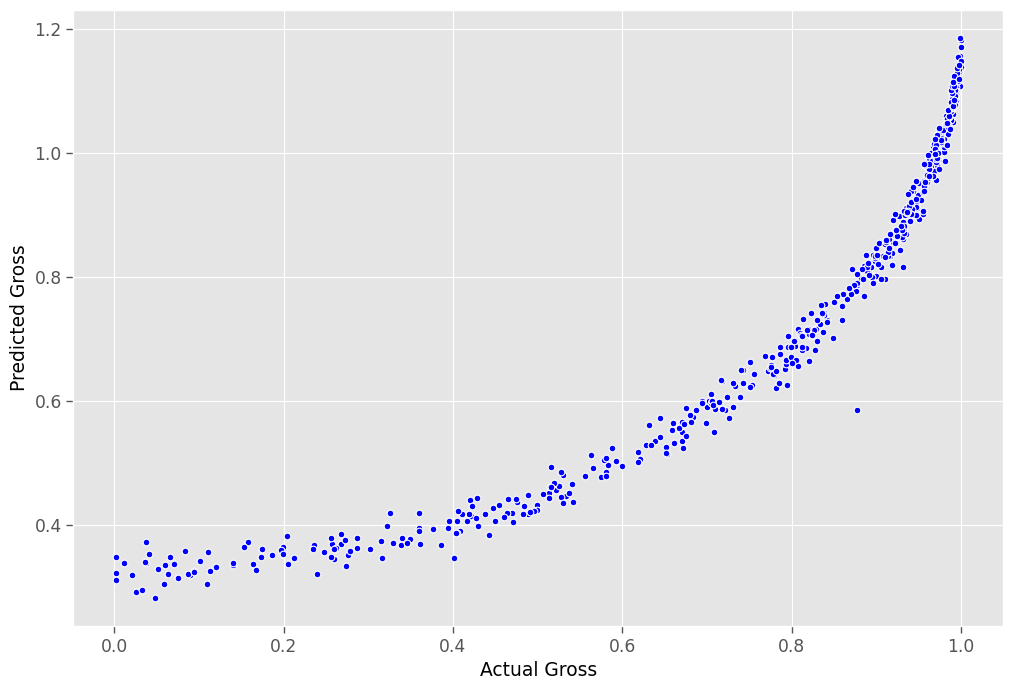

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1033.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:19:50   Log-Likelihood:                 3925.1
No. Observations:                4761   AIC:                            -7792.
Df Residuals:                    4732   BIC:                            -7605.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1000      0.271  

In [42]:
model_scores = pd.DataFrame()

#model performance 
folds = []
R2 = []
adj_R2 = []
intercept = []
mse = []
rmse = []
mae = []

#building the model
X = df_encoded.drop('gross', axis='columns')
y = df_encoded.gross

reg = linear_model.LinearRegression()

#cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

fold = 0
for train_idx, test_idx in kf.split(X,y):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    
    #training
    reg.fit(X_train, y_train)
    pred_y_train = reg.predict(X_train)
    pred_y_test = reg.predict(X_test)
    
    
    #calculating r squared and the adjusted r squared values
    r2 = r2_score(y_test, pred_y_test)
    X1 = sm.add_constant(X_train)
    result = sm.OLS(y_train, X1).fit()
    
    MSE = mean_squared_error(y_test, pred_y_test)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test, pred_y_test)
    
    fold+=1
    folds.append(fold)
    R2.append(r2)
    adj_R2.append(result.rsquared_adj)
    mse.append(MSE)
    rmse.append(RMSE)
    mae.append(MAE)
    
    
    #plot the actual gross vs the predicted gross
    plt.scatter(y_test,pred_y_test,edgecolors='white',c='blue')
    plt.xlabel('Actual Gross')
    plt.ylabel('Predicted Gross')
    plt.show()
    
    print(result.summary())    

#scoring each KFold
cval_score = cross_val_score(reg, X_train, y_train,cv = kf) #scoring each KFold

### Summary of model performance

In [43]:
model_scores['Fold'] = folds
model_scores['Val Score'] = cval_score
model_scores['R2'] = R2
model_scores['Adjusted R2'] = adj_R2
model_scores['MSE'] = mse
model_scores['MAE'] = mae
model_scores['RMSE'] = rmse

model_scores

Fold  Val Score        R2  Adjusted R2       MSE       MAE      RMSE
0     1   0.855913  0.863900     0.857268  0.011117  0.085632  0.105437
1     2   0.857274  0.859961     0.857637  0.010460  0.085165  0.102275
2     3   0.812831  0.793642     0.859653  0.017879  0.094772  0.133711
3     4   0.854068  0.858094     0.857814  0.011243  0.084506  0.106034
4     5   0.850091  0.845493     0.859211  0.012308  0.089635  0.110940
5     6   0.864905  0.861824     0.857341  0.011559  0.086406  0.107511
6     7   0.852952  0.861383     0.857512  0.011522  0.087493  0.107340
7     8   0.858148  0.846987     0.858882  0.011249  0.089242  0.106060
8     9   0.852114  0.864454     0.857297  0.010529  0.084601  0.102609
9    10   0.864107  0.850900     0.858583  0.011917  0.089619  0.109166

In [44]:
print(f'mean cross val score: {np.mean(cval_score)}')
print(f'mean R2: {np.mean(R2)}')
print(f'mean Adjusted R2: {np.mean(adj_R2)}')
print(f'mean MSE: {np.mean(mse)}')
print(f'mean MAE: {np.mean(mae)}')
print(f'mean RMSE: {np.mean(rmse)}')

mean cross val score: 0.8522402195789507
mean R2: 0.850663784353203
mean Adjusted R2: 0.858119734140862
mean MSE: 0.011978180496005473
mean MAE: 0.0877069839576607
mean RMSE: 0.10910833686693784


# Check model assumptions

## Residual vs predictor plot

In [45]:
def residual_plot(features):
    for col in features.columns:
        fig = plt.figure(figsize=(12,8))
        fig = sm.graphics.plot_regress_exog(result, col, fig=fig)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


C:\Users\mflor\AppData\Local\Temp\ipykernel_11528\3121822032.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


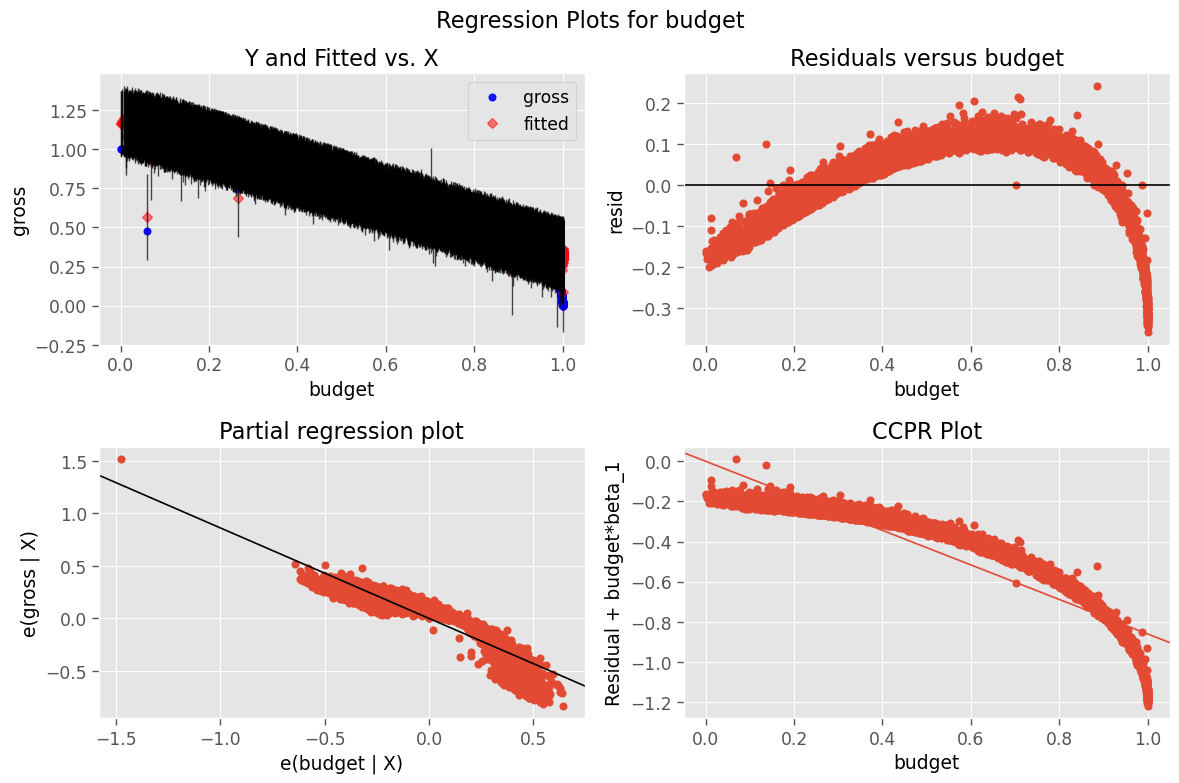

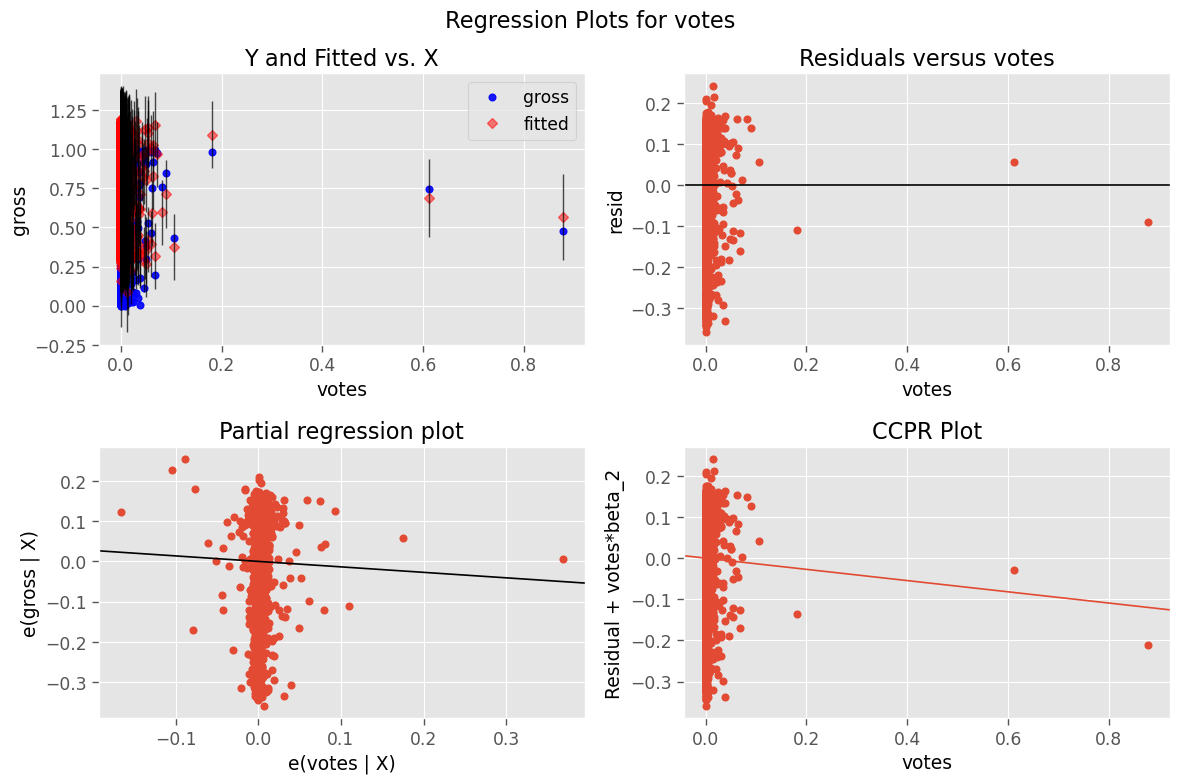

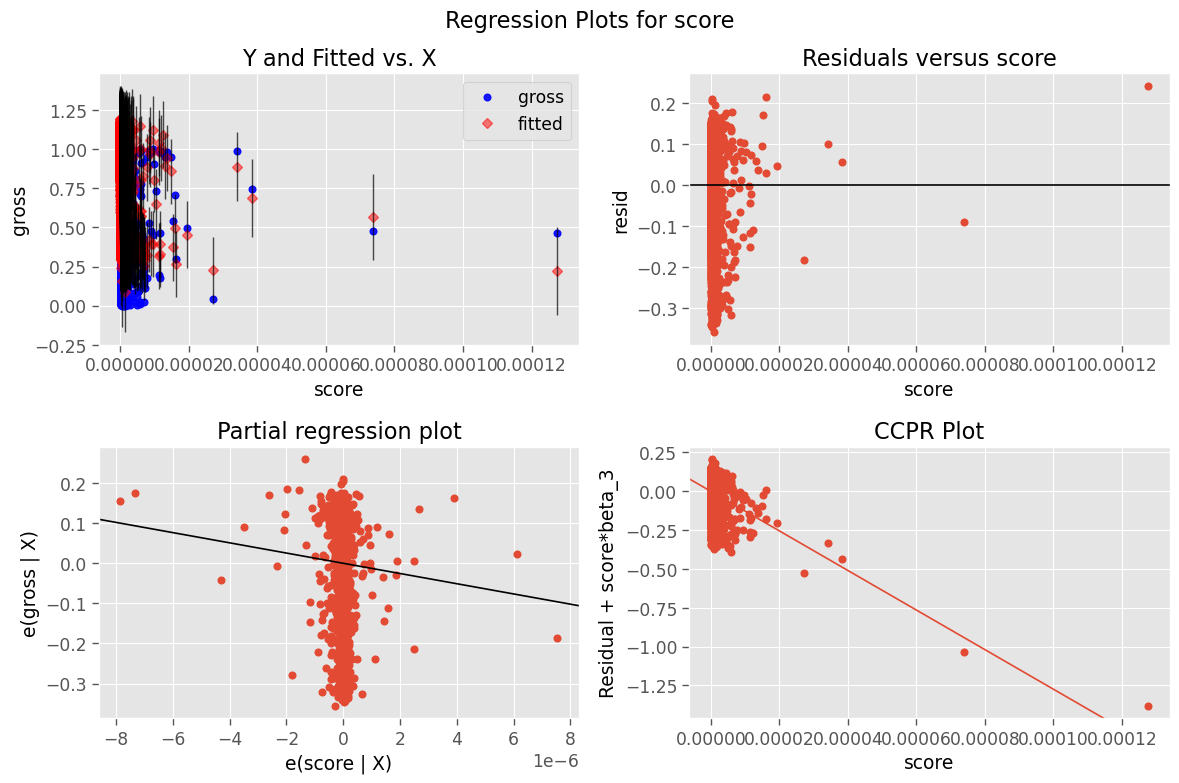

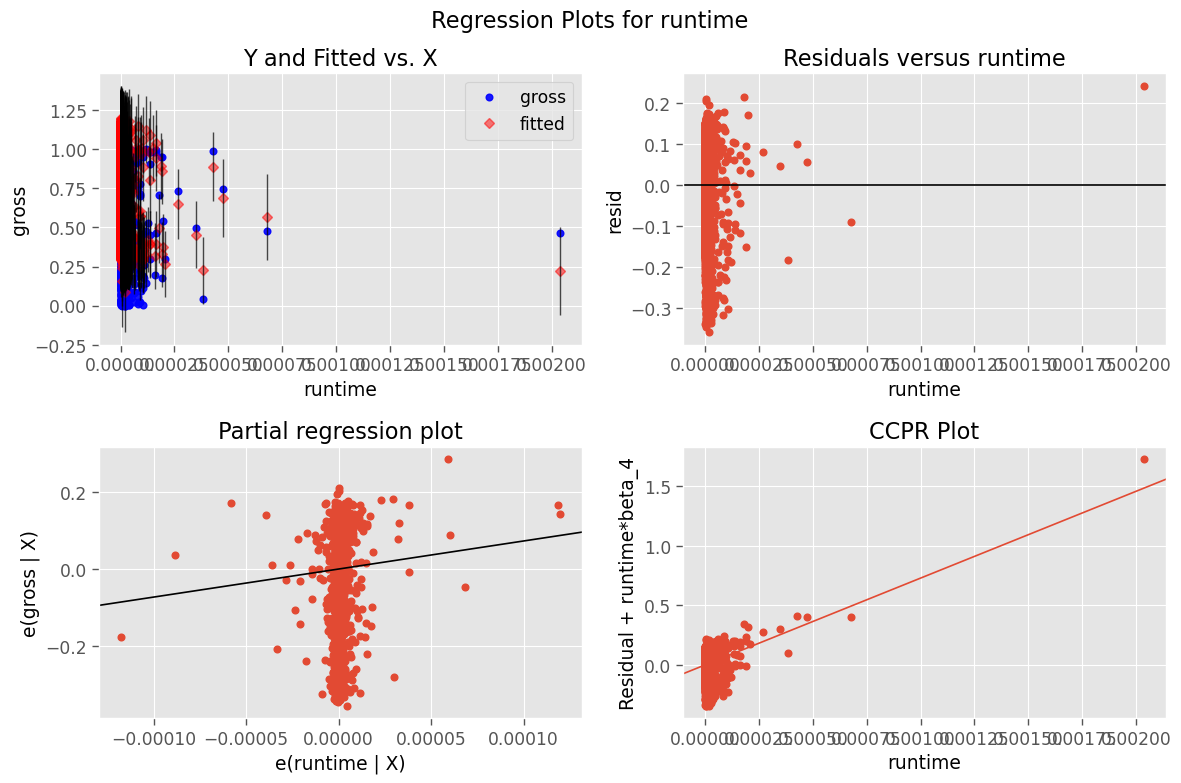

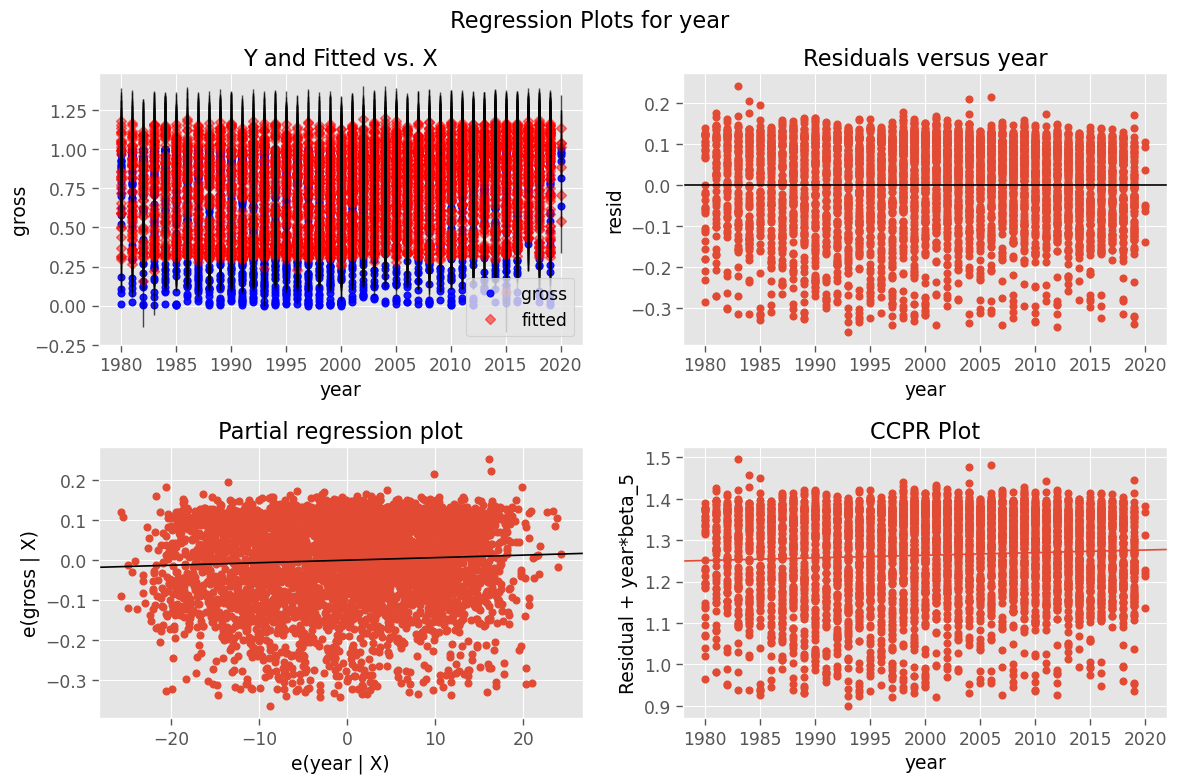

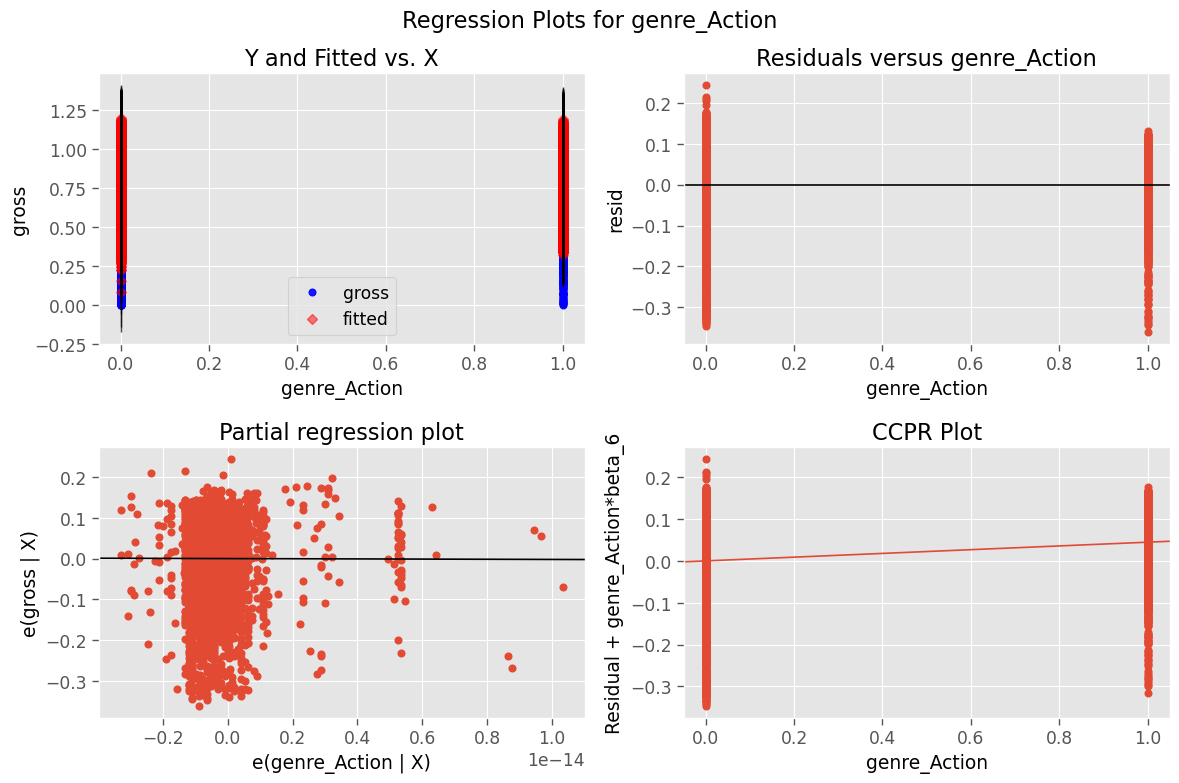

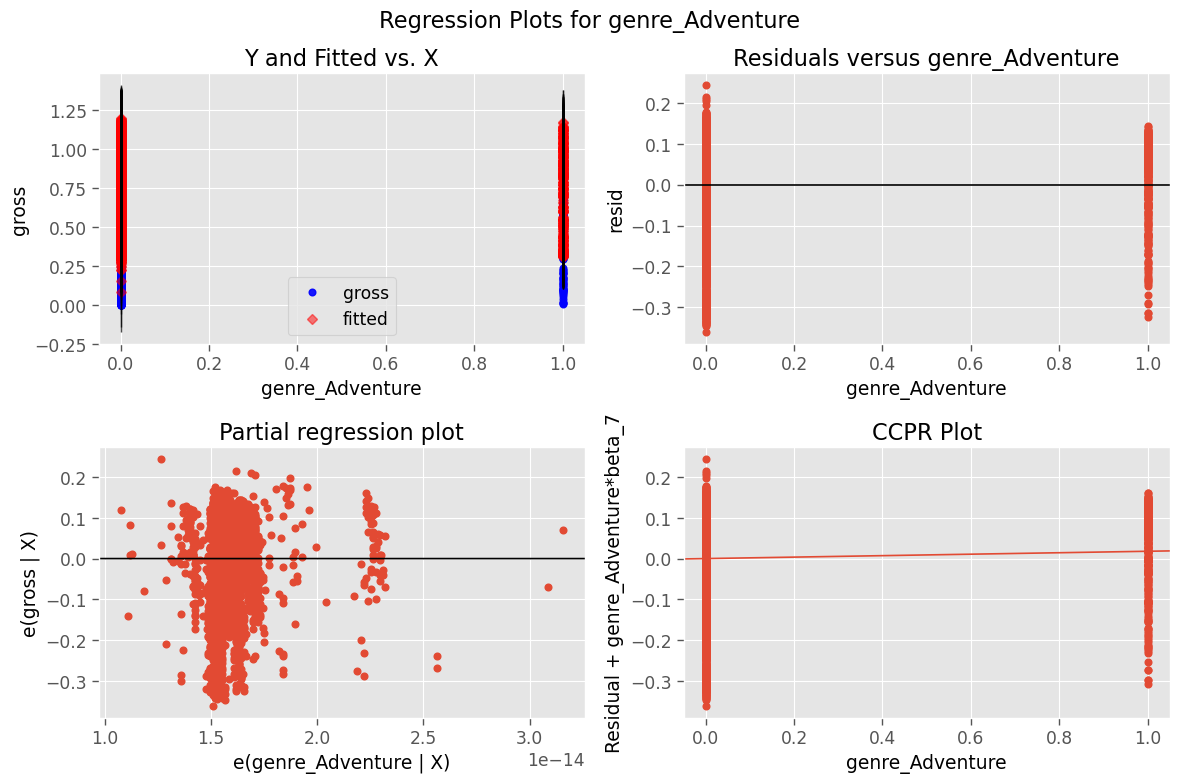

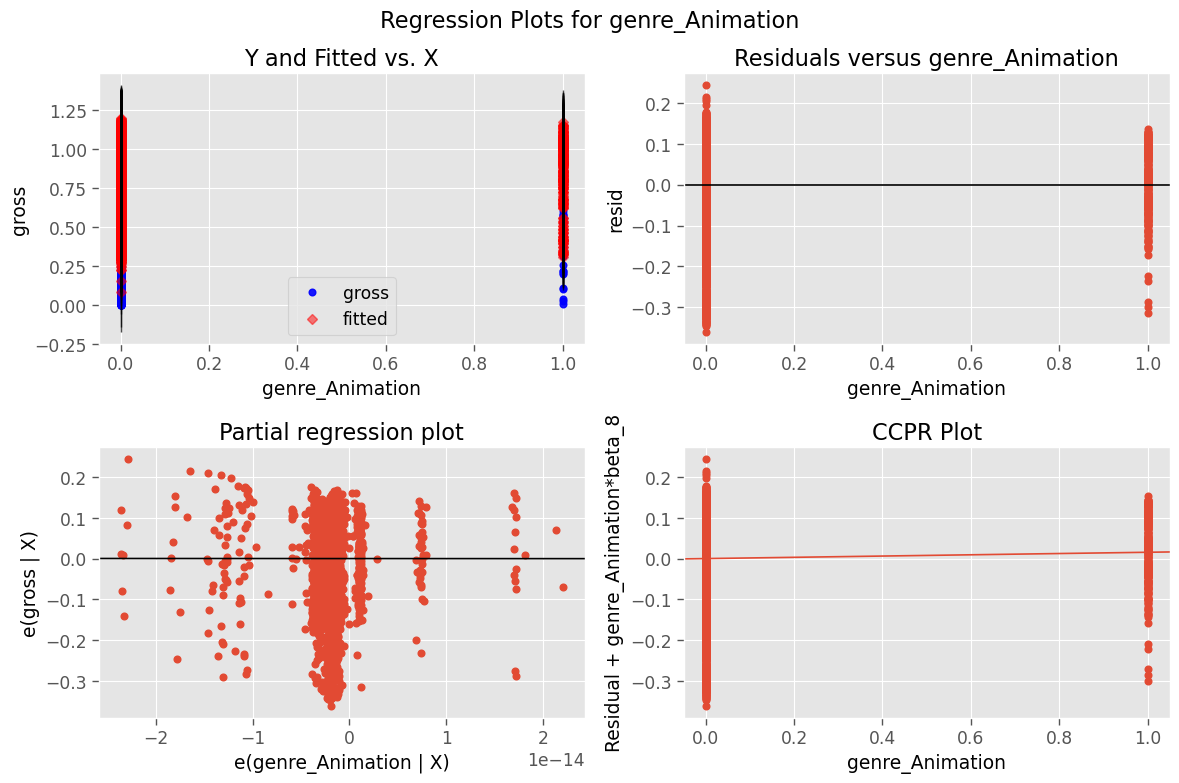

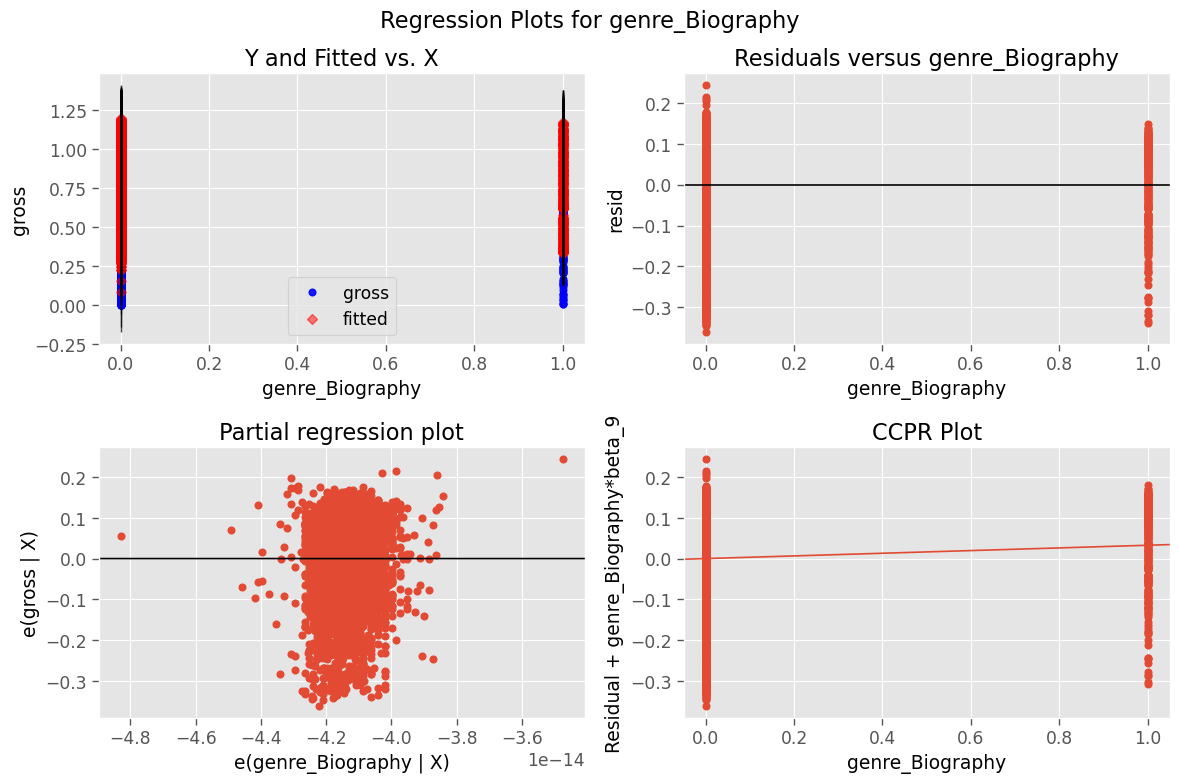

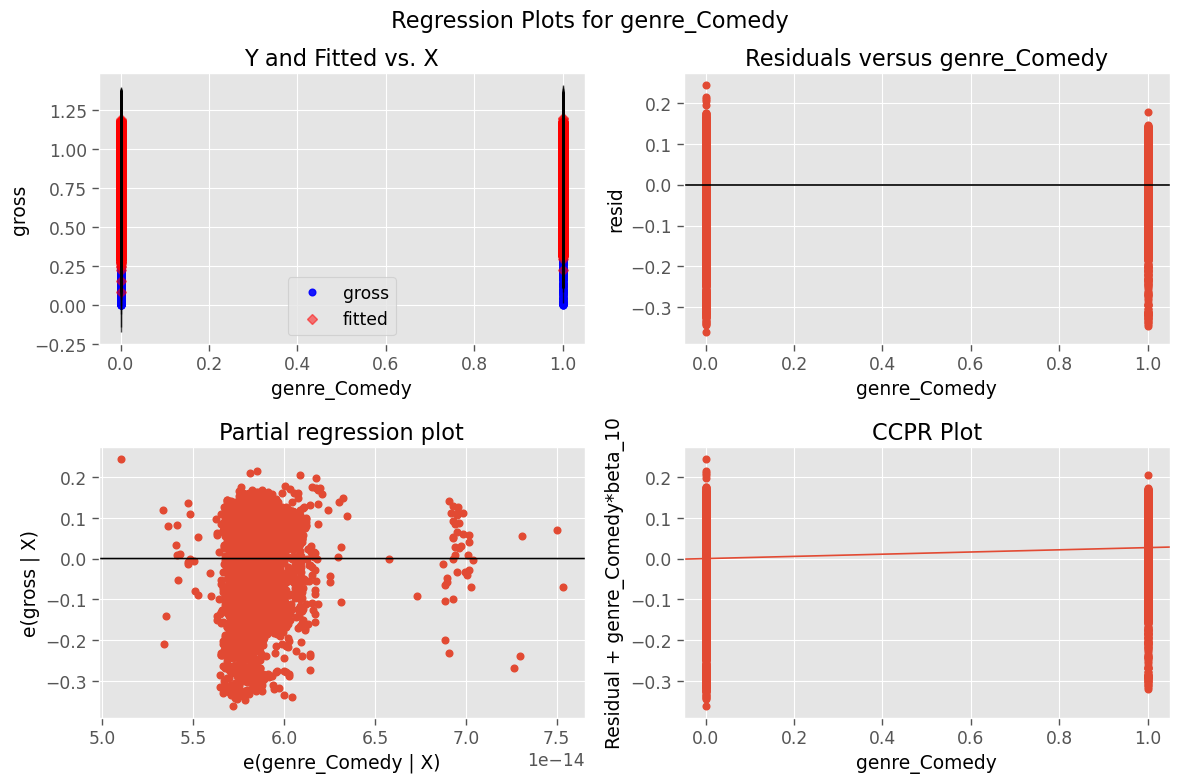

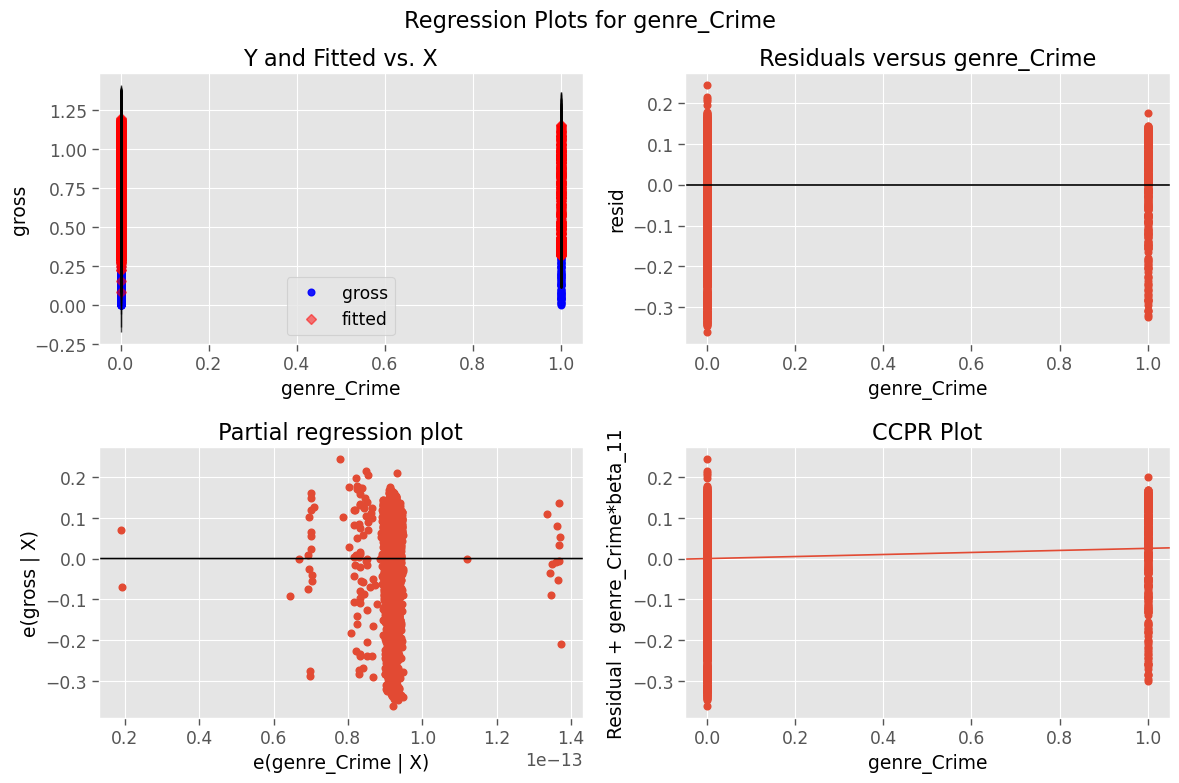

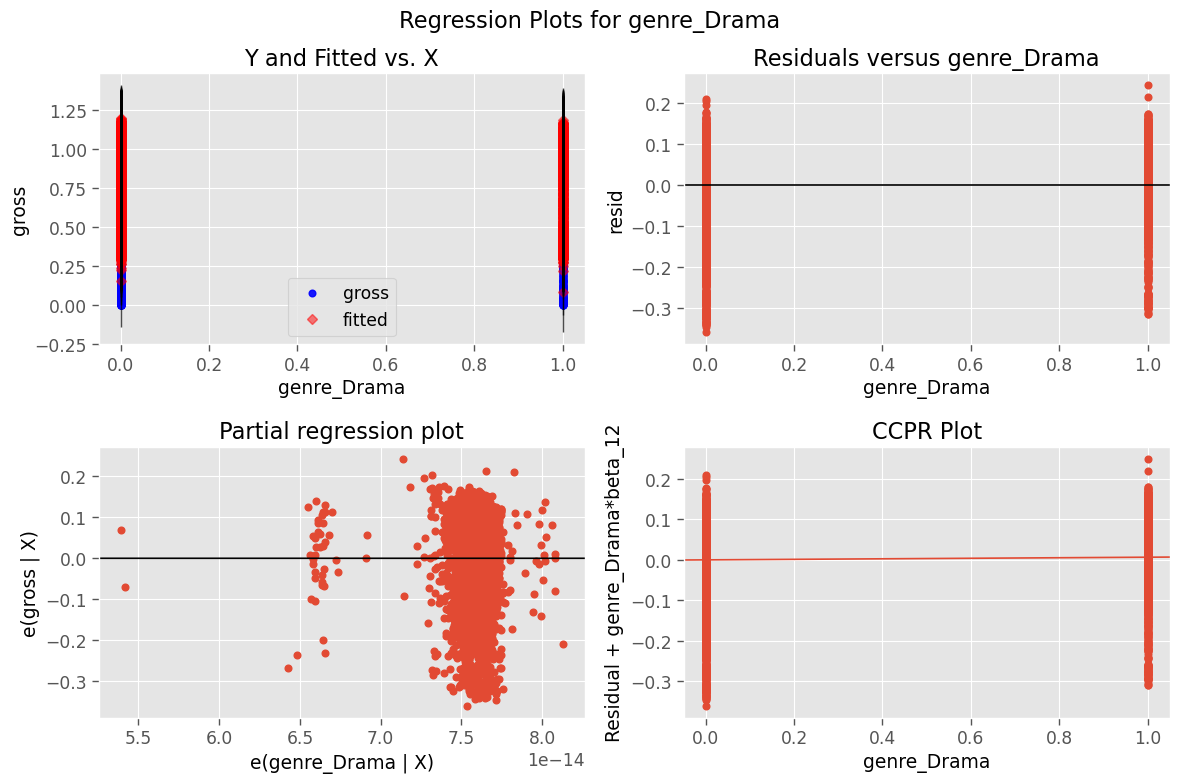

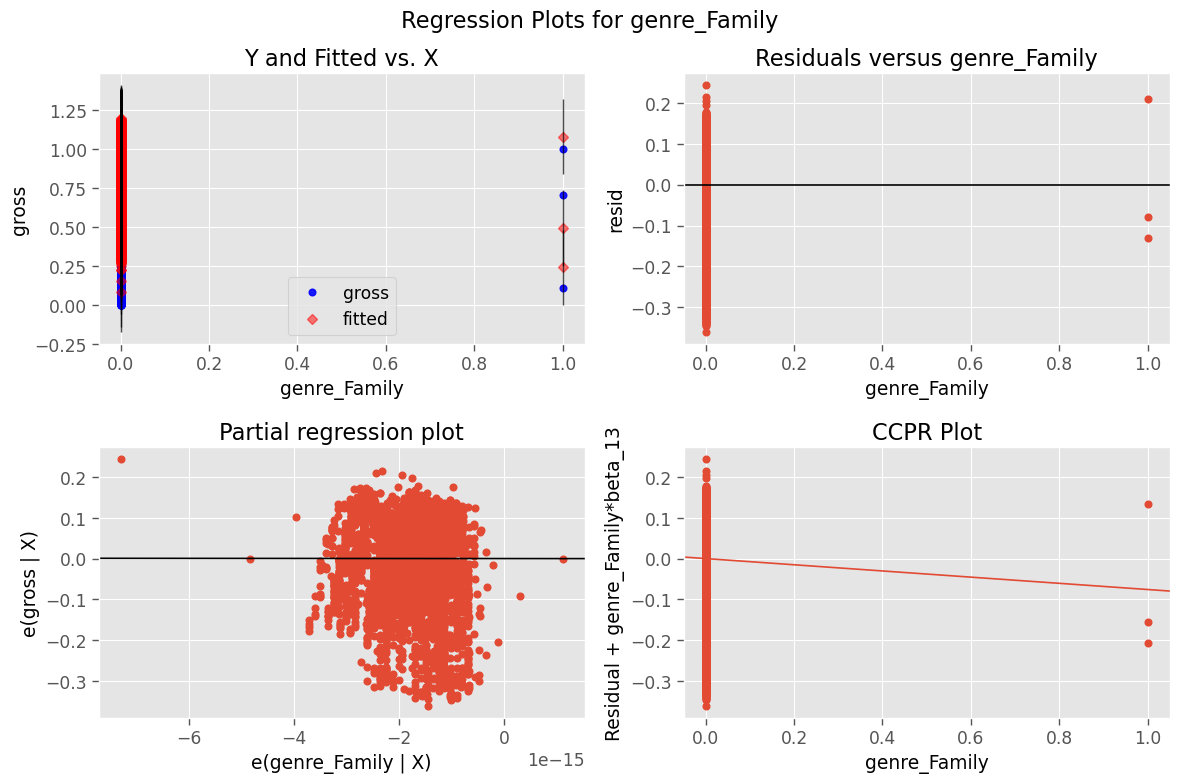

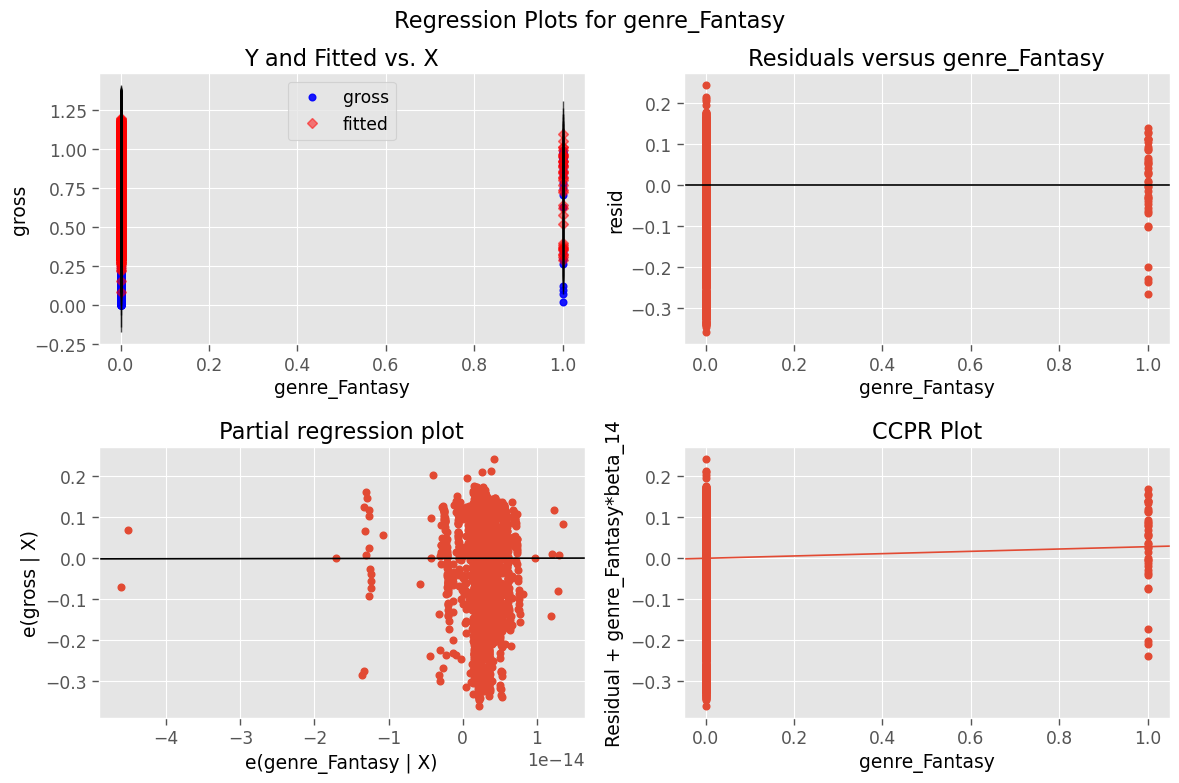

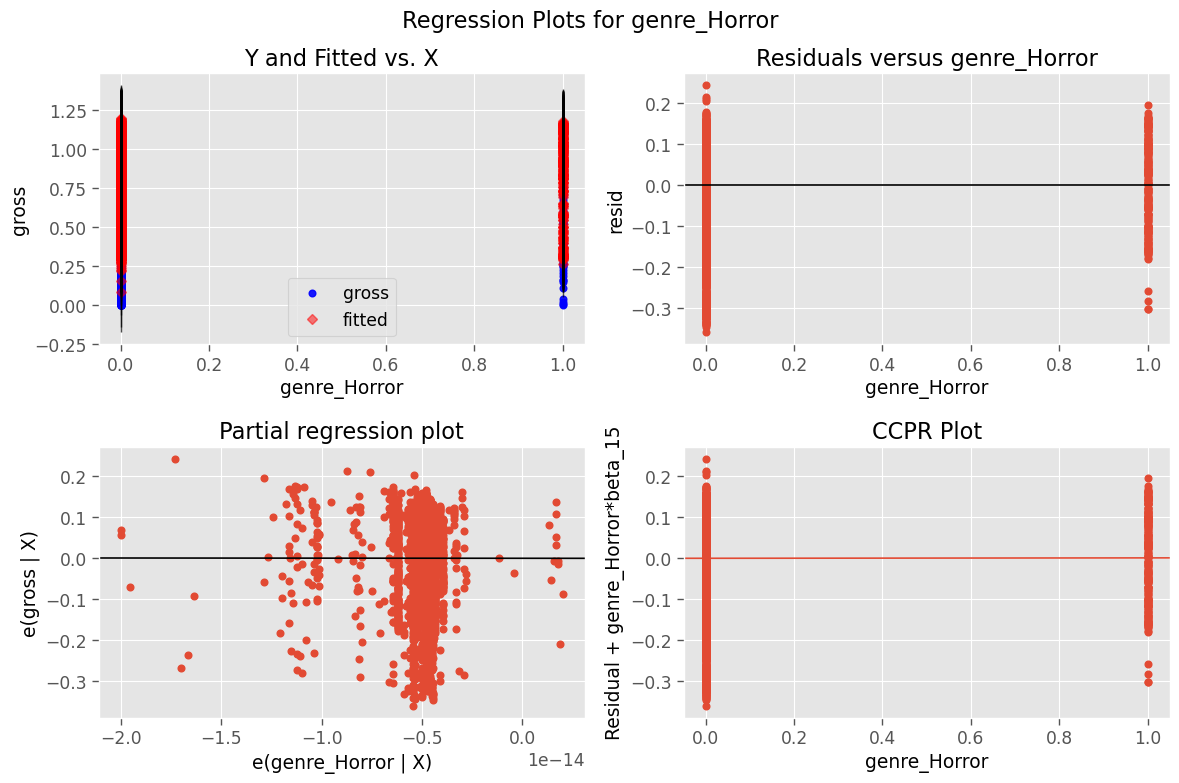

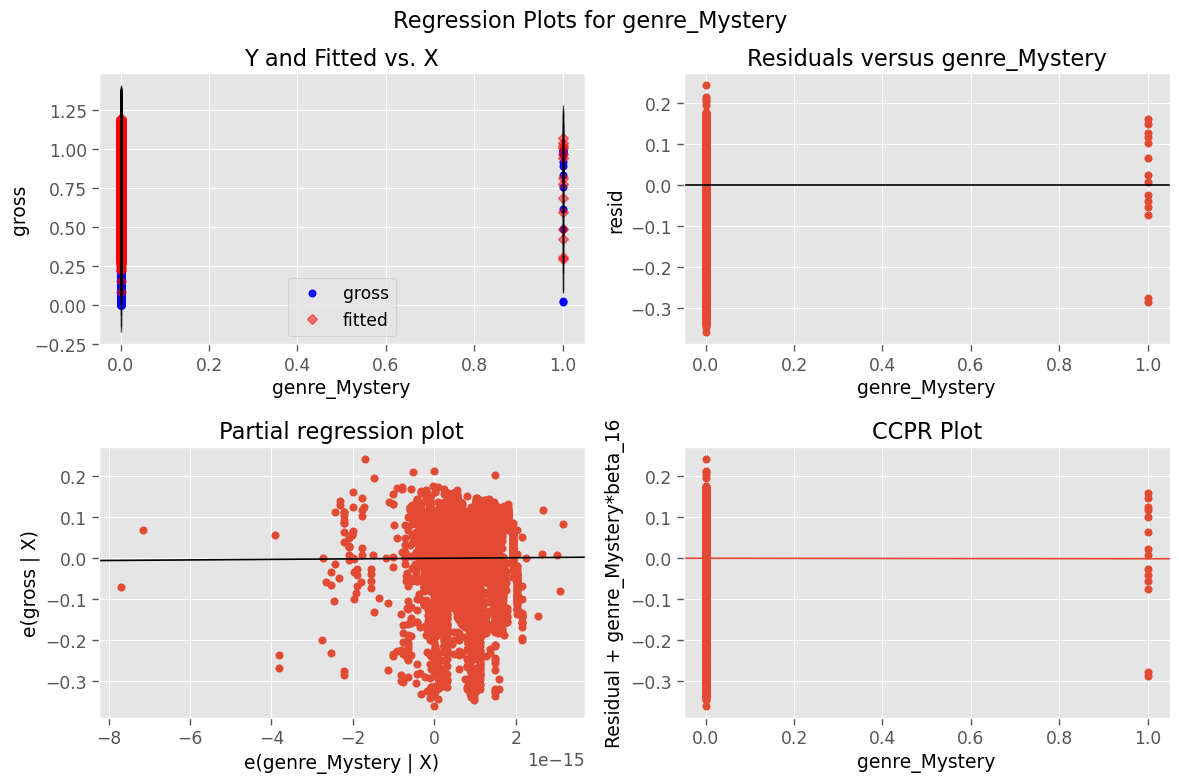

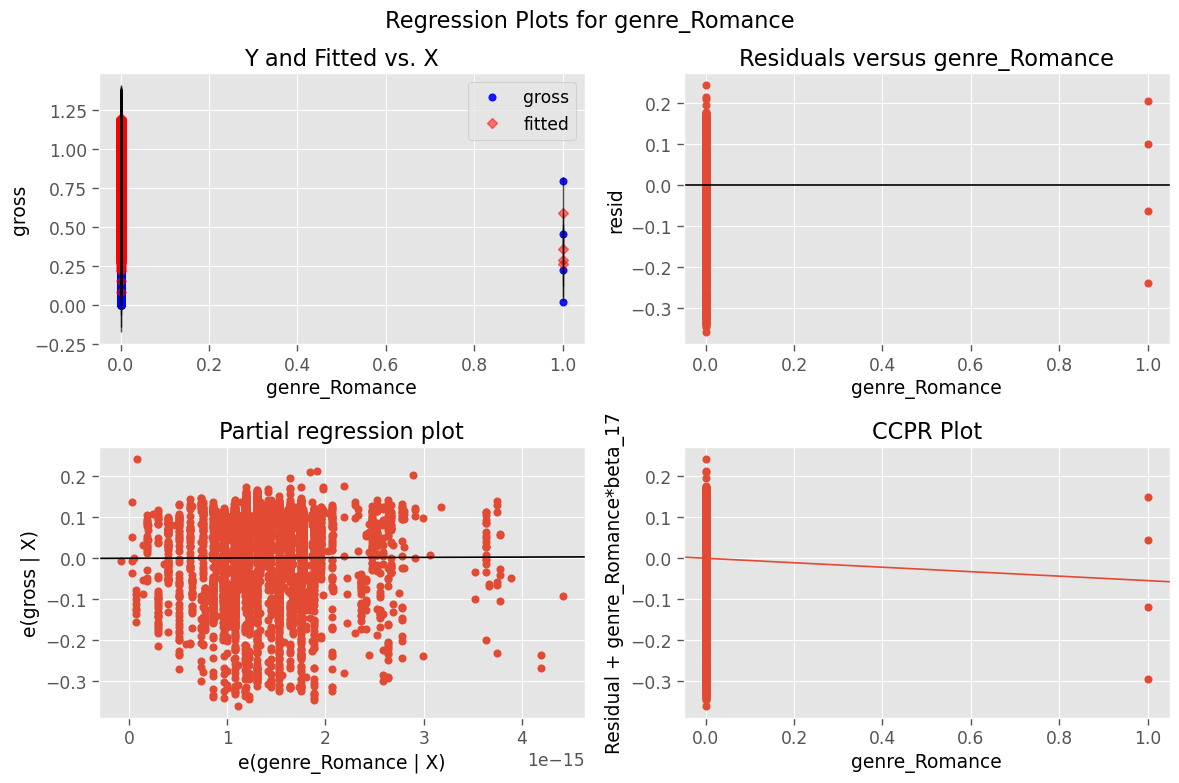

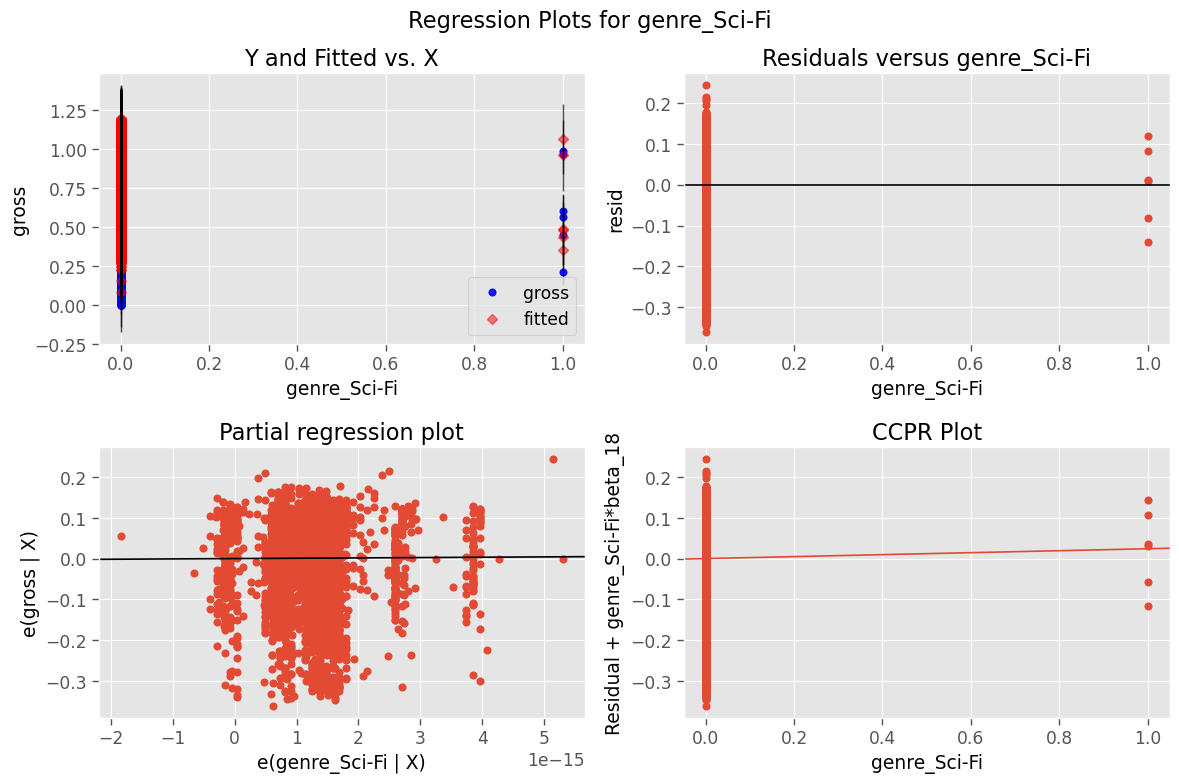

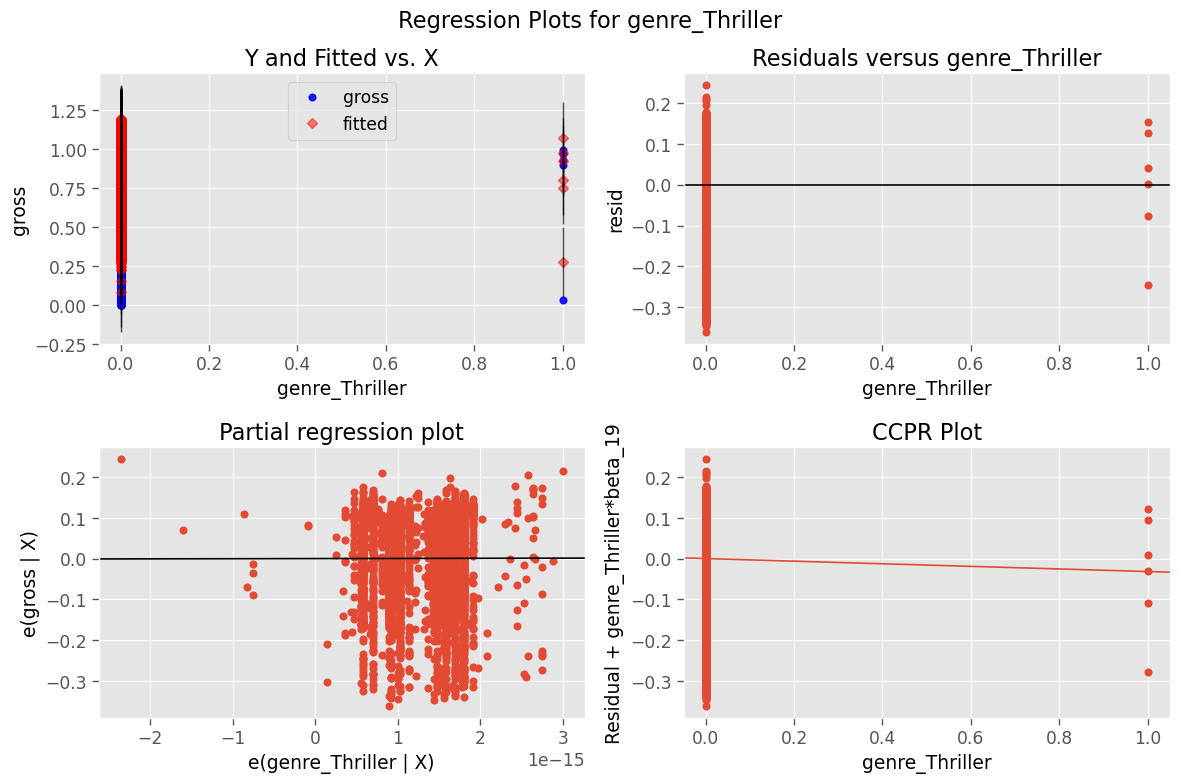

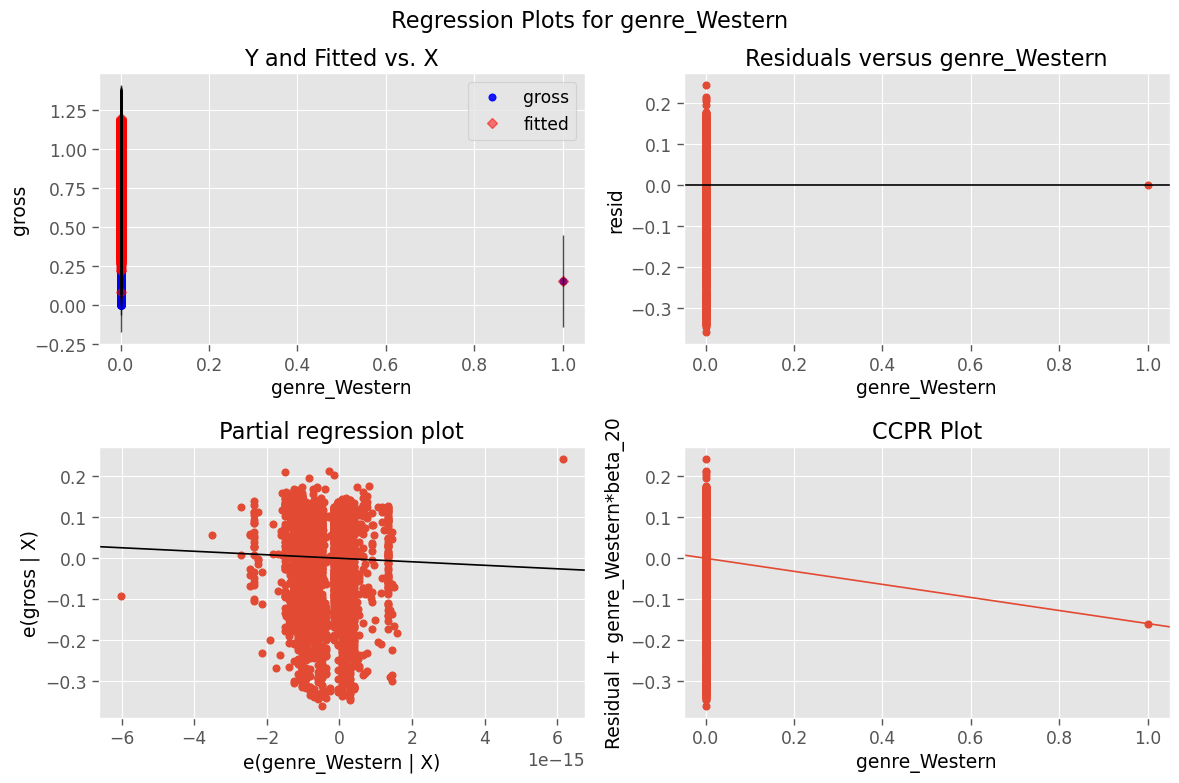

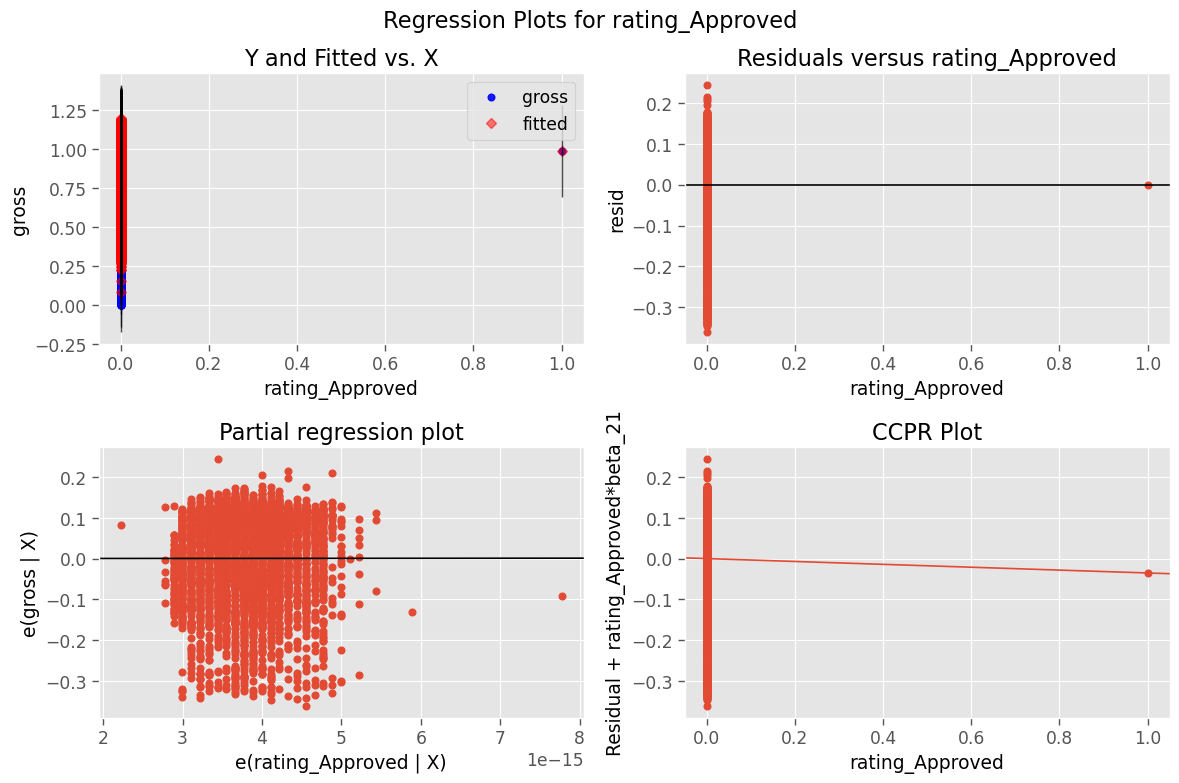

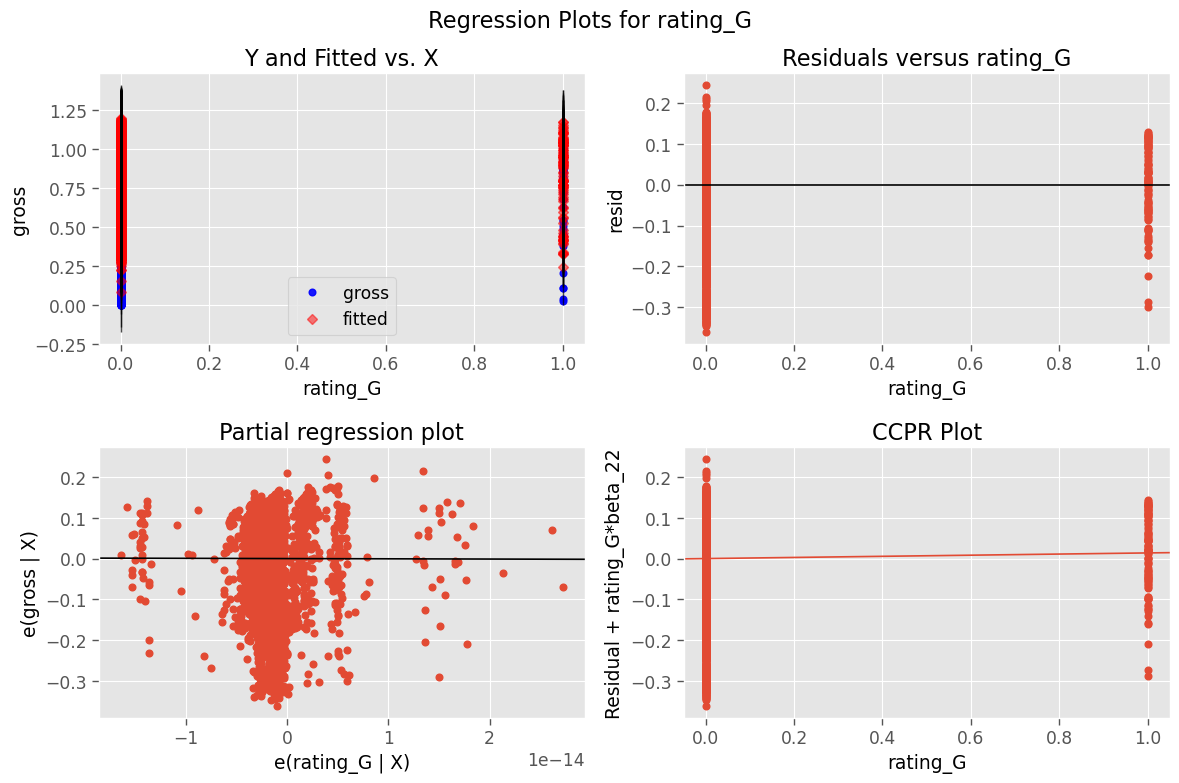

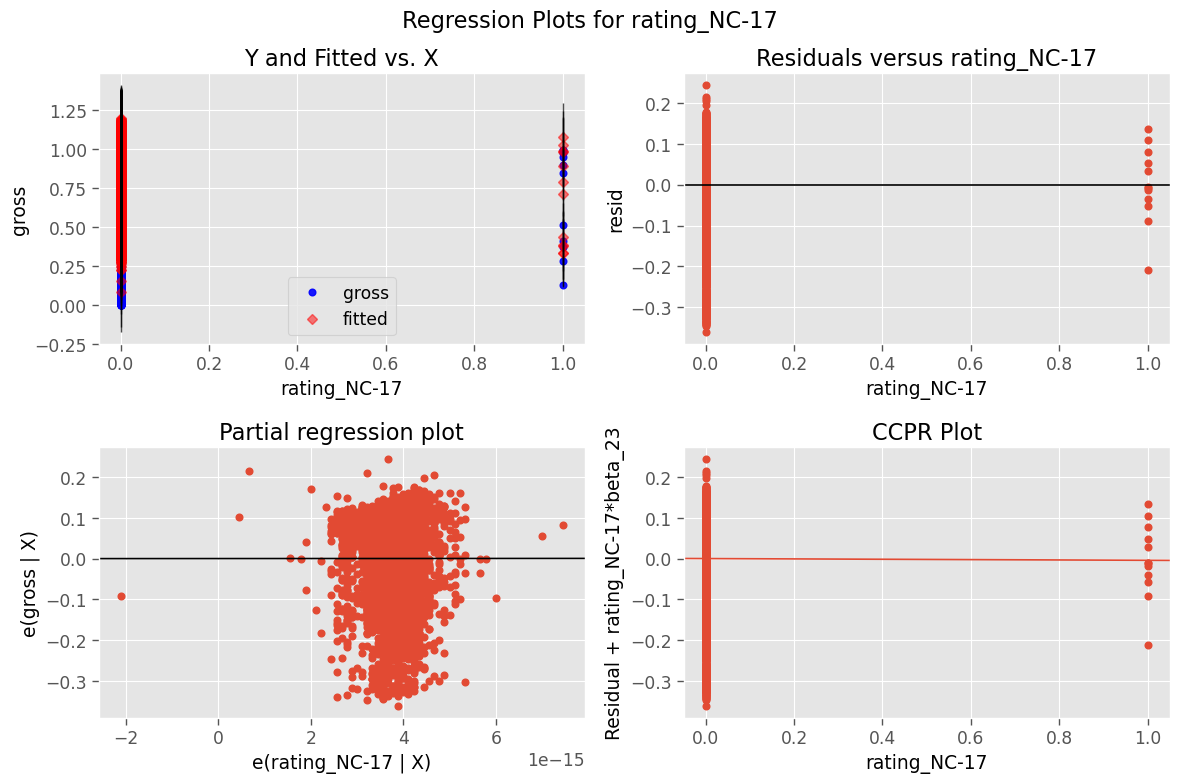

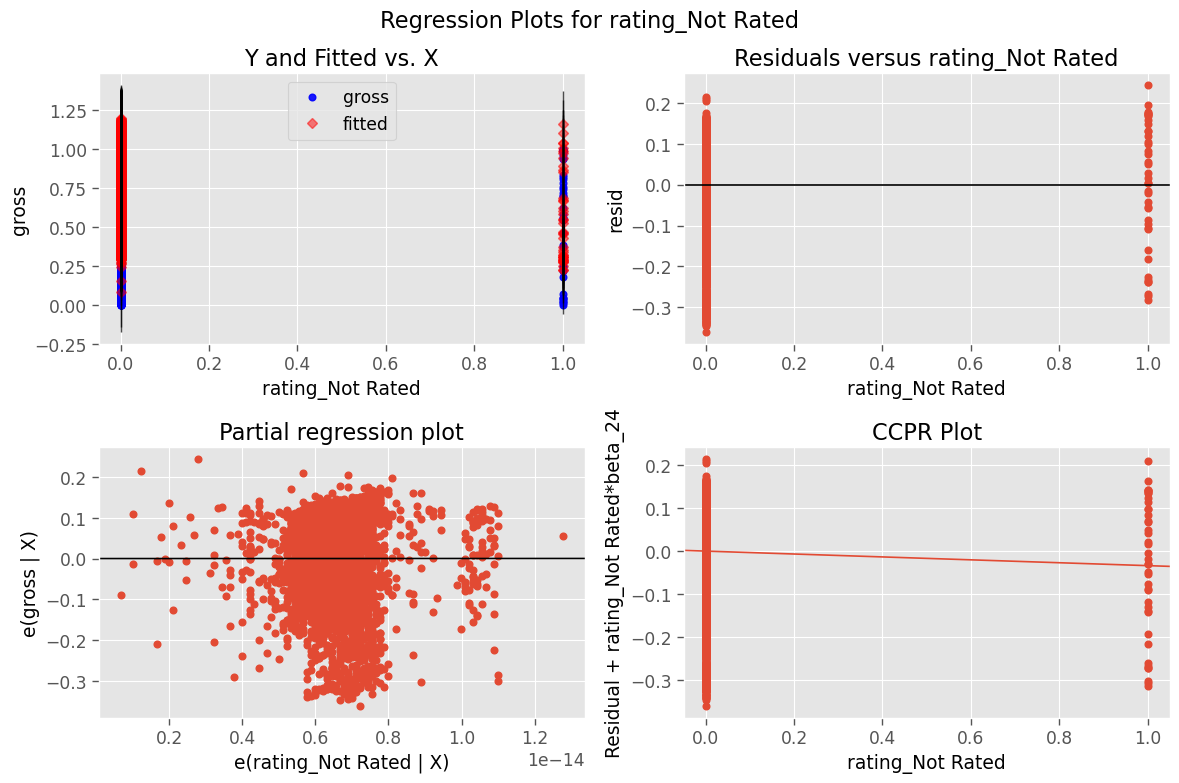

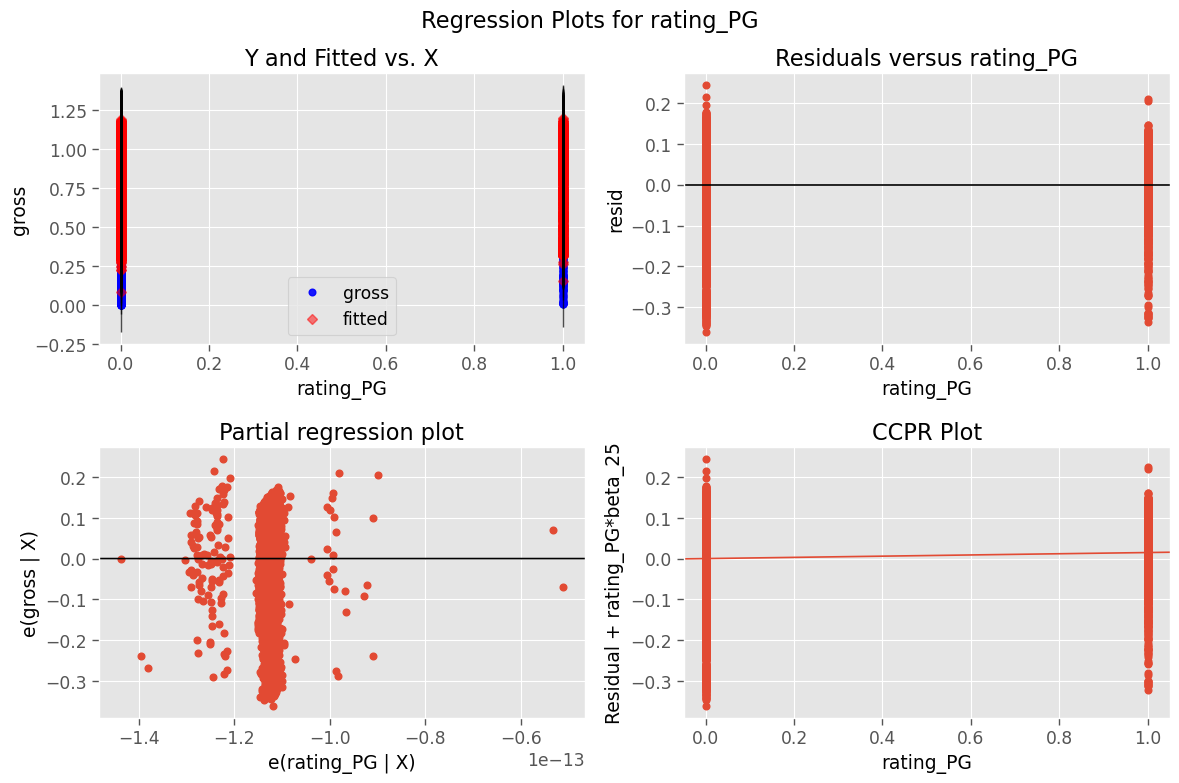

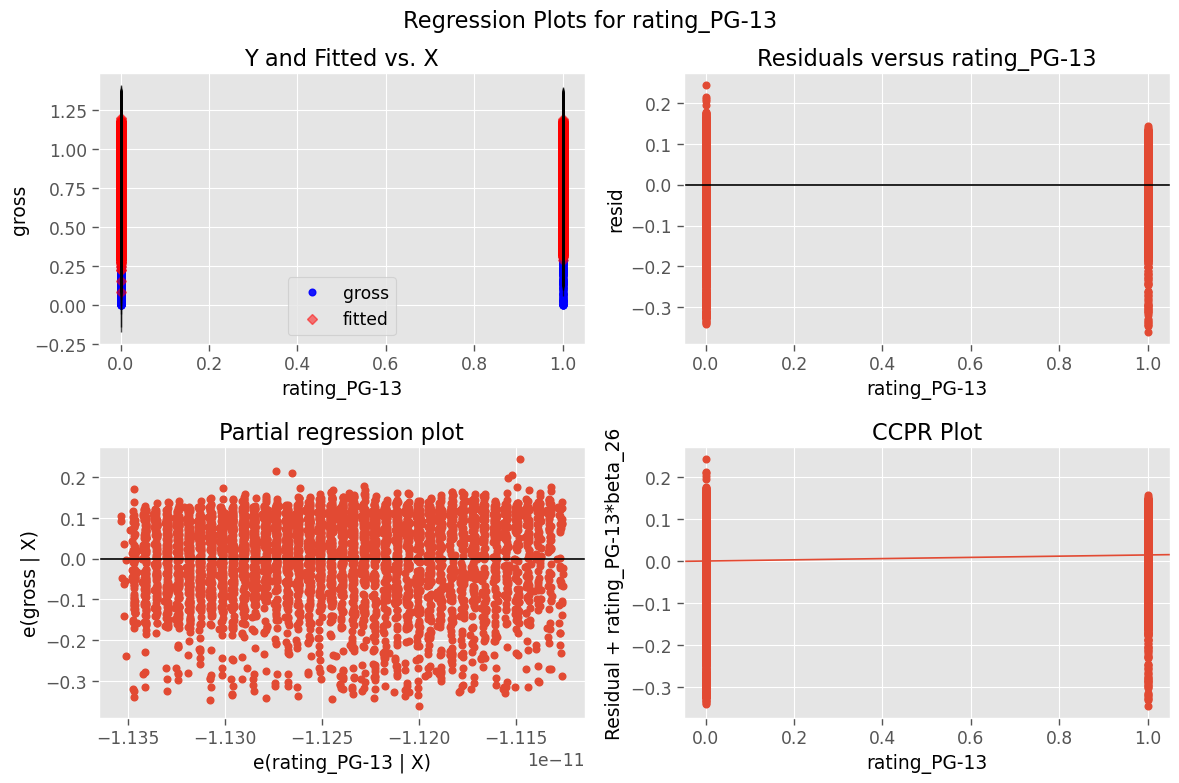

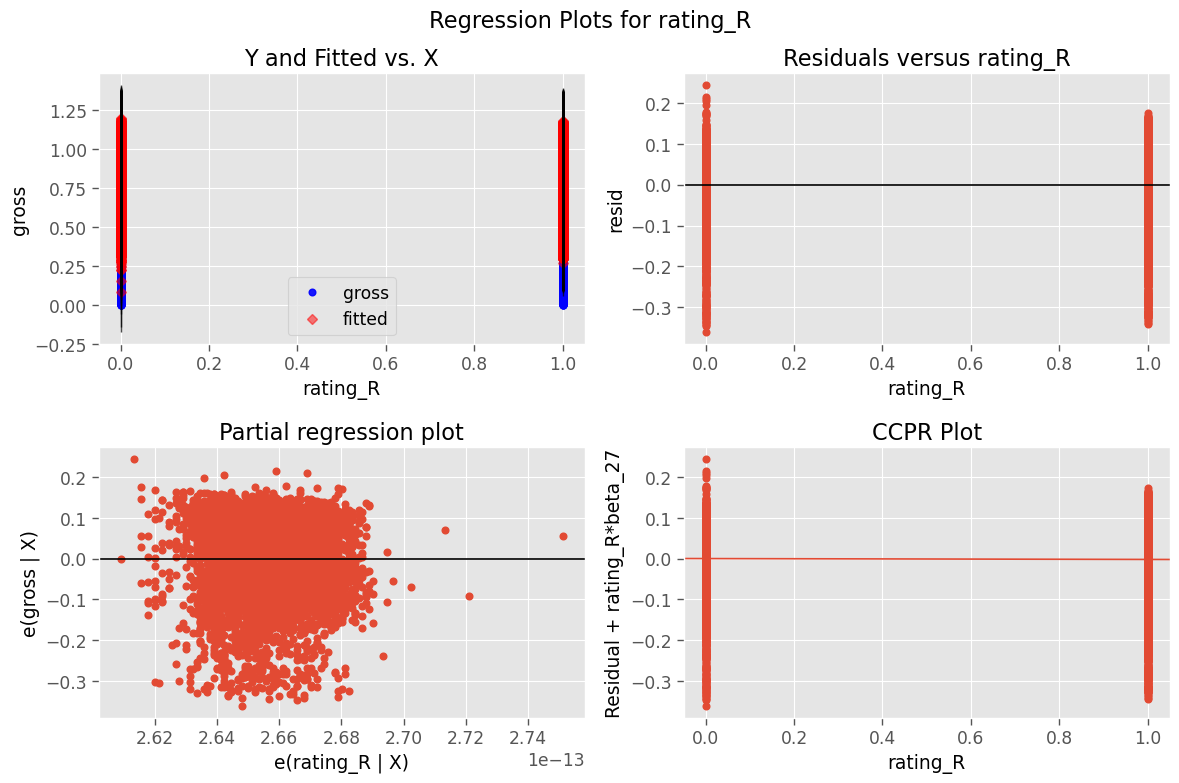

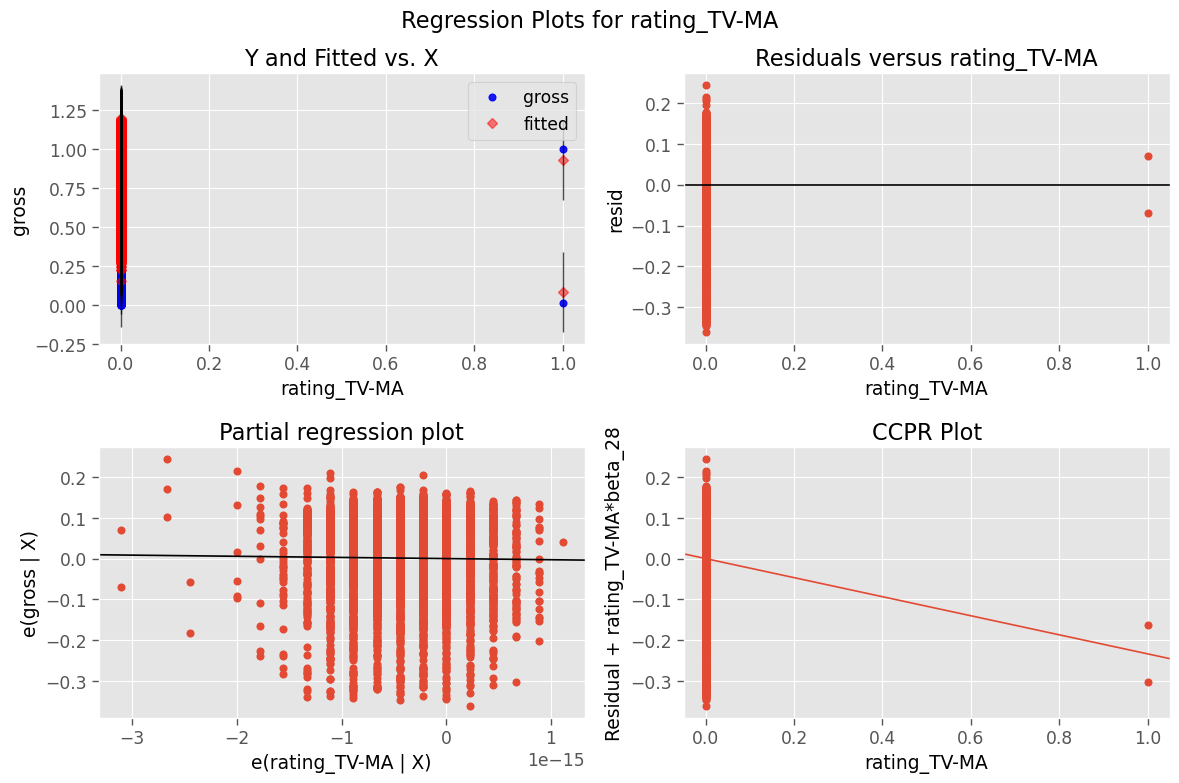

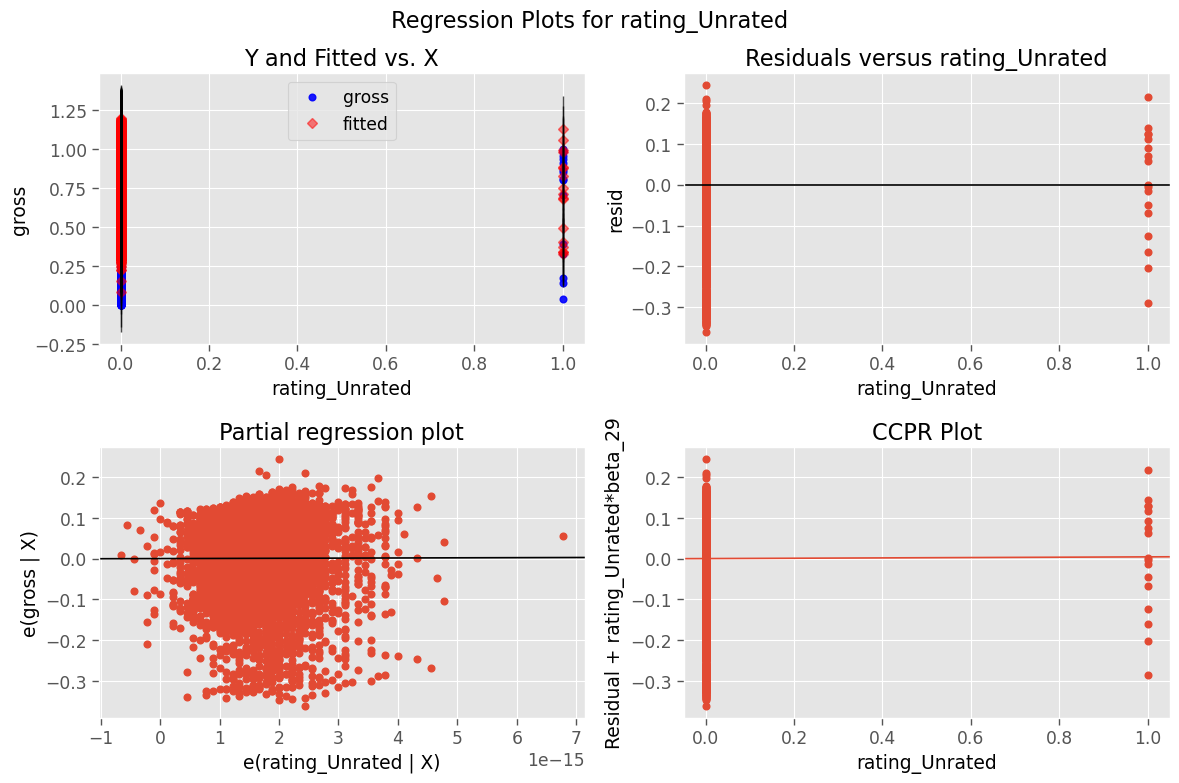

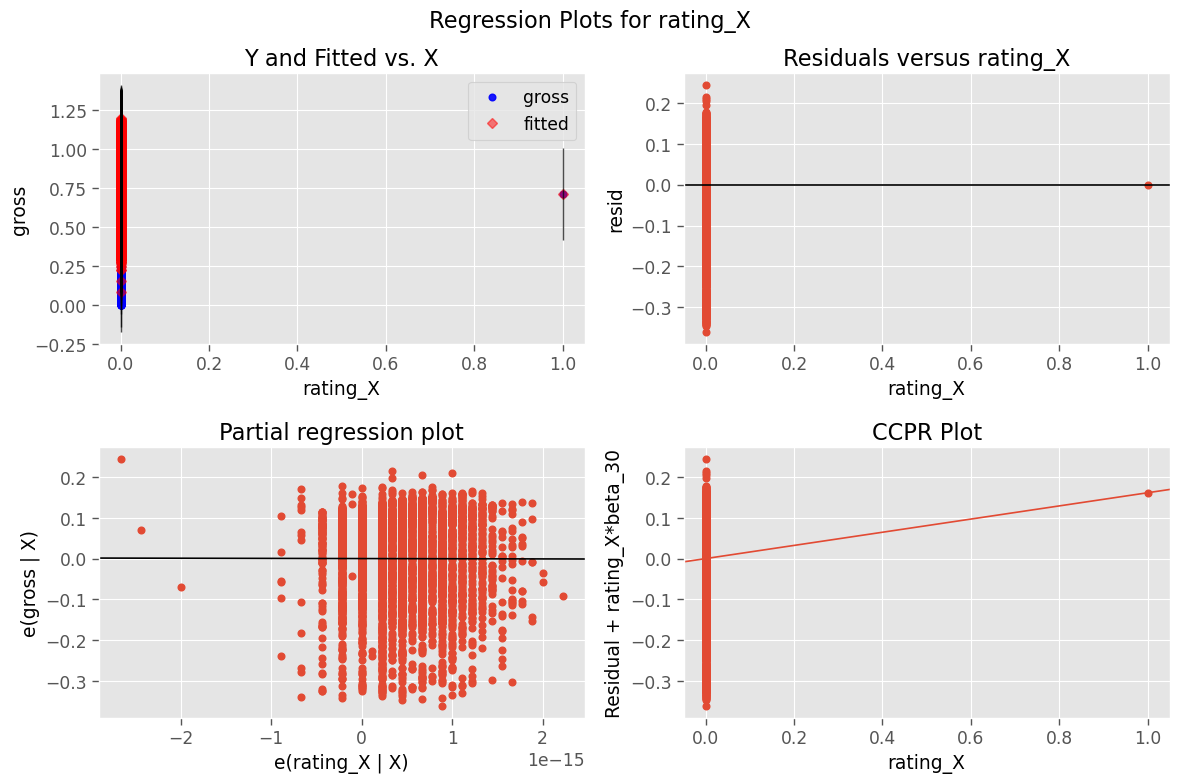

In [46]:
residual_plot(X)

systematic curviture, i.e. non normality, for budget. high variance in the residuals. most other features have relatively consistent variance of the residuals. the assumed linear relationship between budget and gross is potentially not reasonable.